In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os

sys.path.append("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
%aimport plotting
%aimport umi_deduplicate

from tqdm import tqdm  # progress bar

In [ ]:
! pwd

In [6]:
#CHANGE?
AD = finder.Barcode(name = "AD",
                       preceder = "GGCTAGC",
                       post = "TGACTAG",
                       length = 120)

AD_BC = finder.Barcode(name = "AD_BC",
                       preceder = "CGCGCC",
                       post = "GGGCCC",
                       length = 11)

RPTR_BC = finder.Barcode(name = "RPTR_BC",
                       preceder = "CTCGAG",
                       post = "GGCCGC",
                       length = 14)


# Step1 February 2024
data: /global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2024/A10_A11/results/A11_S2.fastq.gz.assembled.fastq



Initial map made at /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/ChopTFs/step1_step2_initial_maps.py

Base prefix (stable across descriptors): step1_AD_AD_BC_RPTR_BC_
Full prefix for this instance: step1_AD_AD_BC_RPTR_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. barcode_exists
5. unique_target
6. quality_designed

Grouping step1_AD_AD_BC_RPTR_BC_initial...
Skipping — table step1_AD_AD_BC_RPTR_BC_initial_grouped already exists and is initial/grouped.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

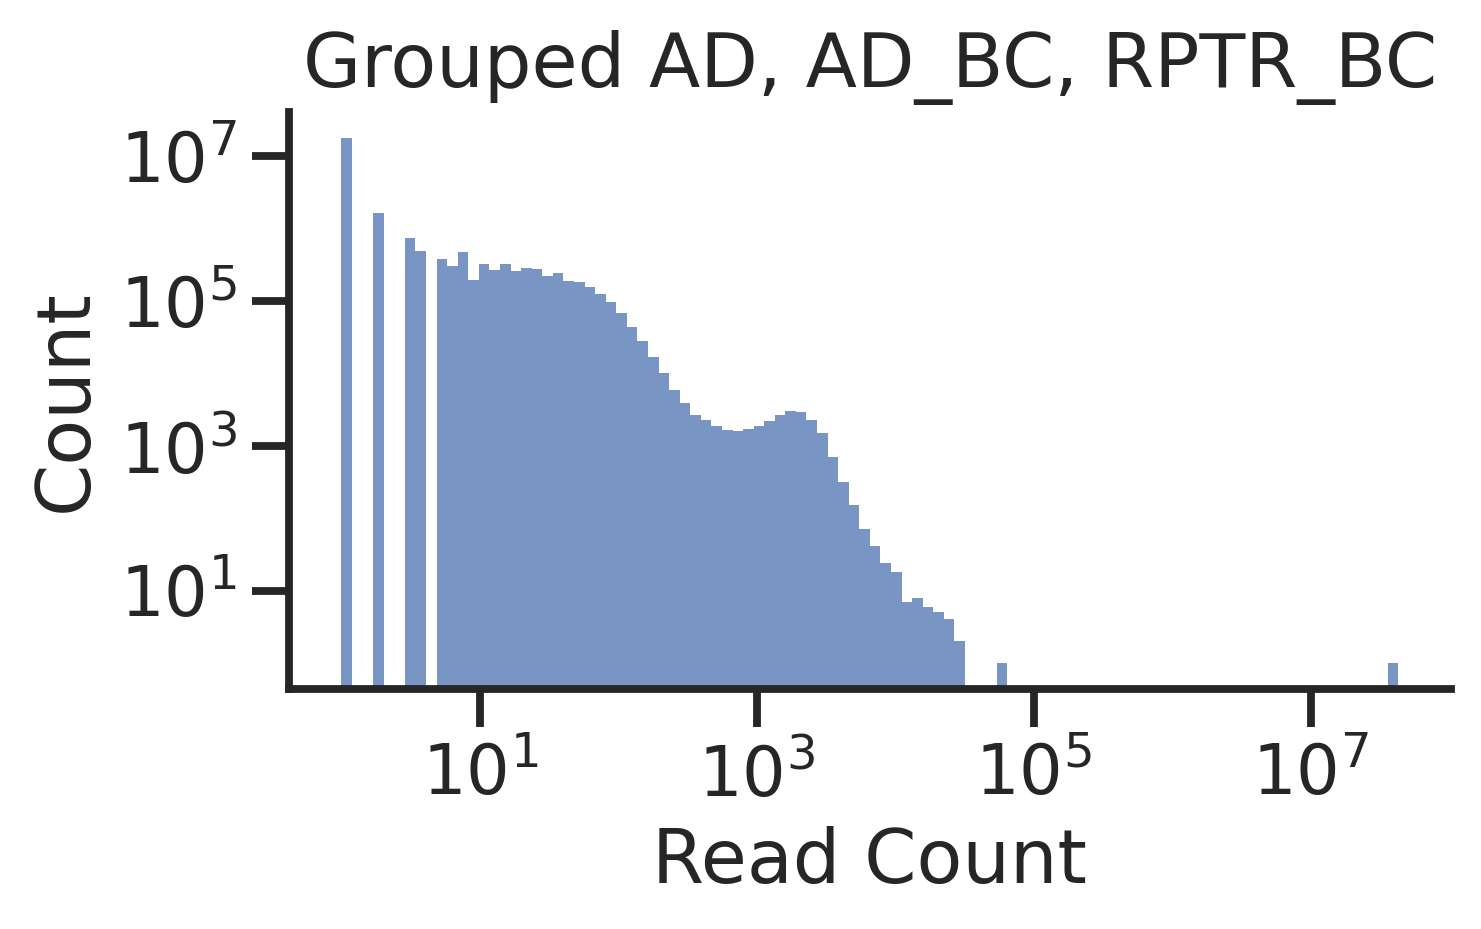

Done in 19.92 seconds.

Thresholding...
Using reads threshold of 10.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

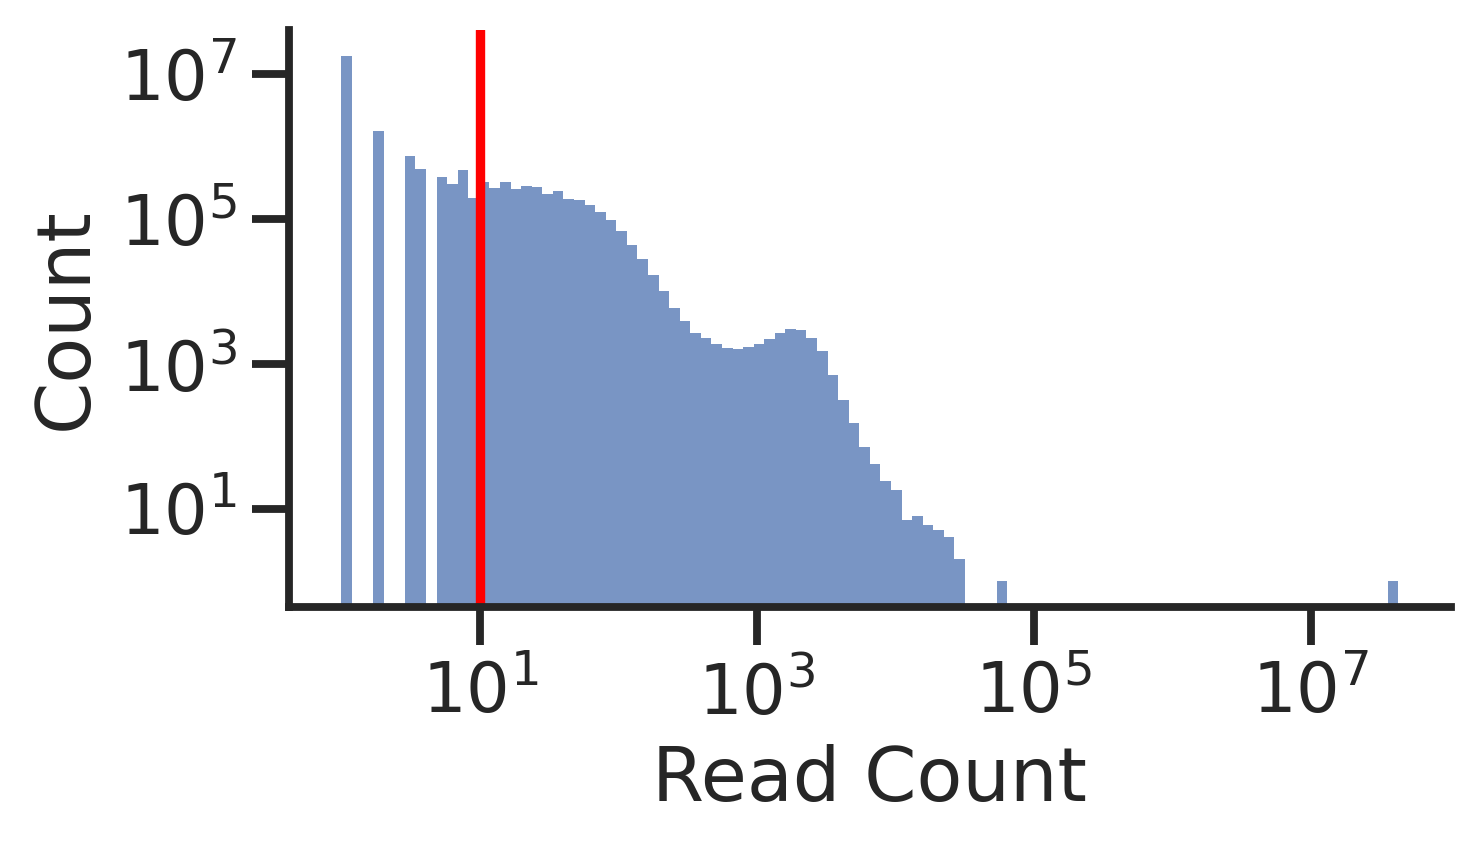

Done in 20.38 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 1.62 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: RPTR_BC → AD
Created filtered table: step1_AD_AD_BC_RPTR_BC_unique_target
Done in 1.42 seconds.

Filtering to quality and designed...
Done in 0.43 seconds.

Done.


In [70]:
# Refiner
refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs.db",
                                bc_objects = [AD, AD_BC, RPTR_BC],
                                column_pairs = [("RPTR_BC", "AD")],
                                design_check = True, 
                                 reads_threshold = 10,#CHANGE
                                map_order = ['grouped', 'thresholded', 'barcode_exists', 'unique_target', 'quality', 'designed'],
                                step_name = "step1",
                                should_check_exists = True,
                                 plot_histograms=True,
                                output_figures_path="../../output/ChopTFs/figures/") #CHANGE
refiner.refine_map_from_db()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_loss_summary'
Done in 2.80 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

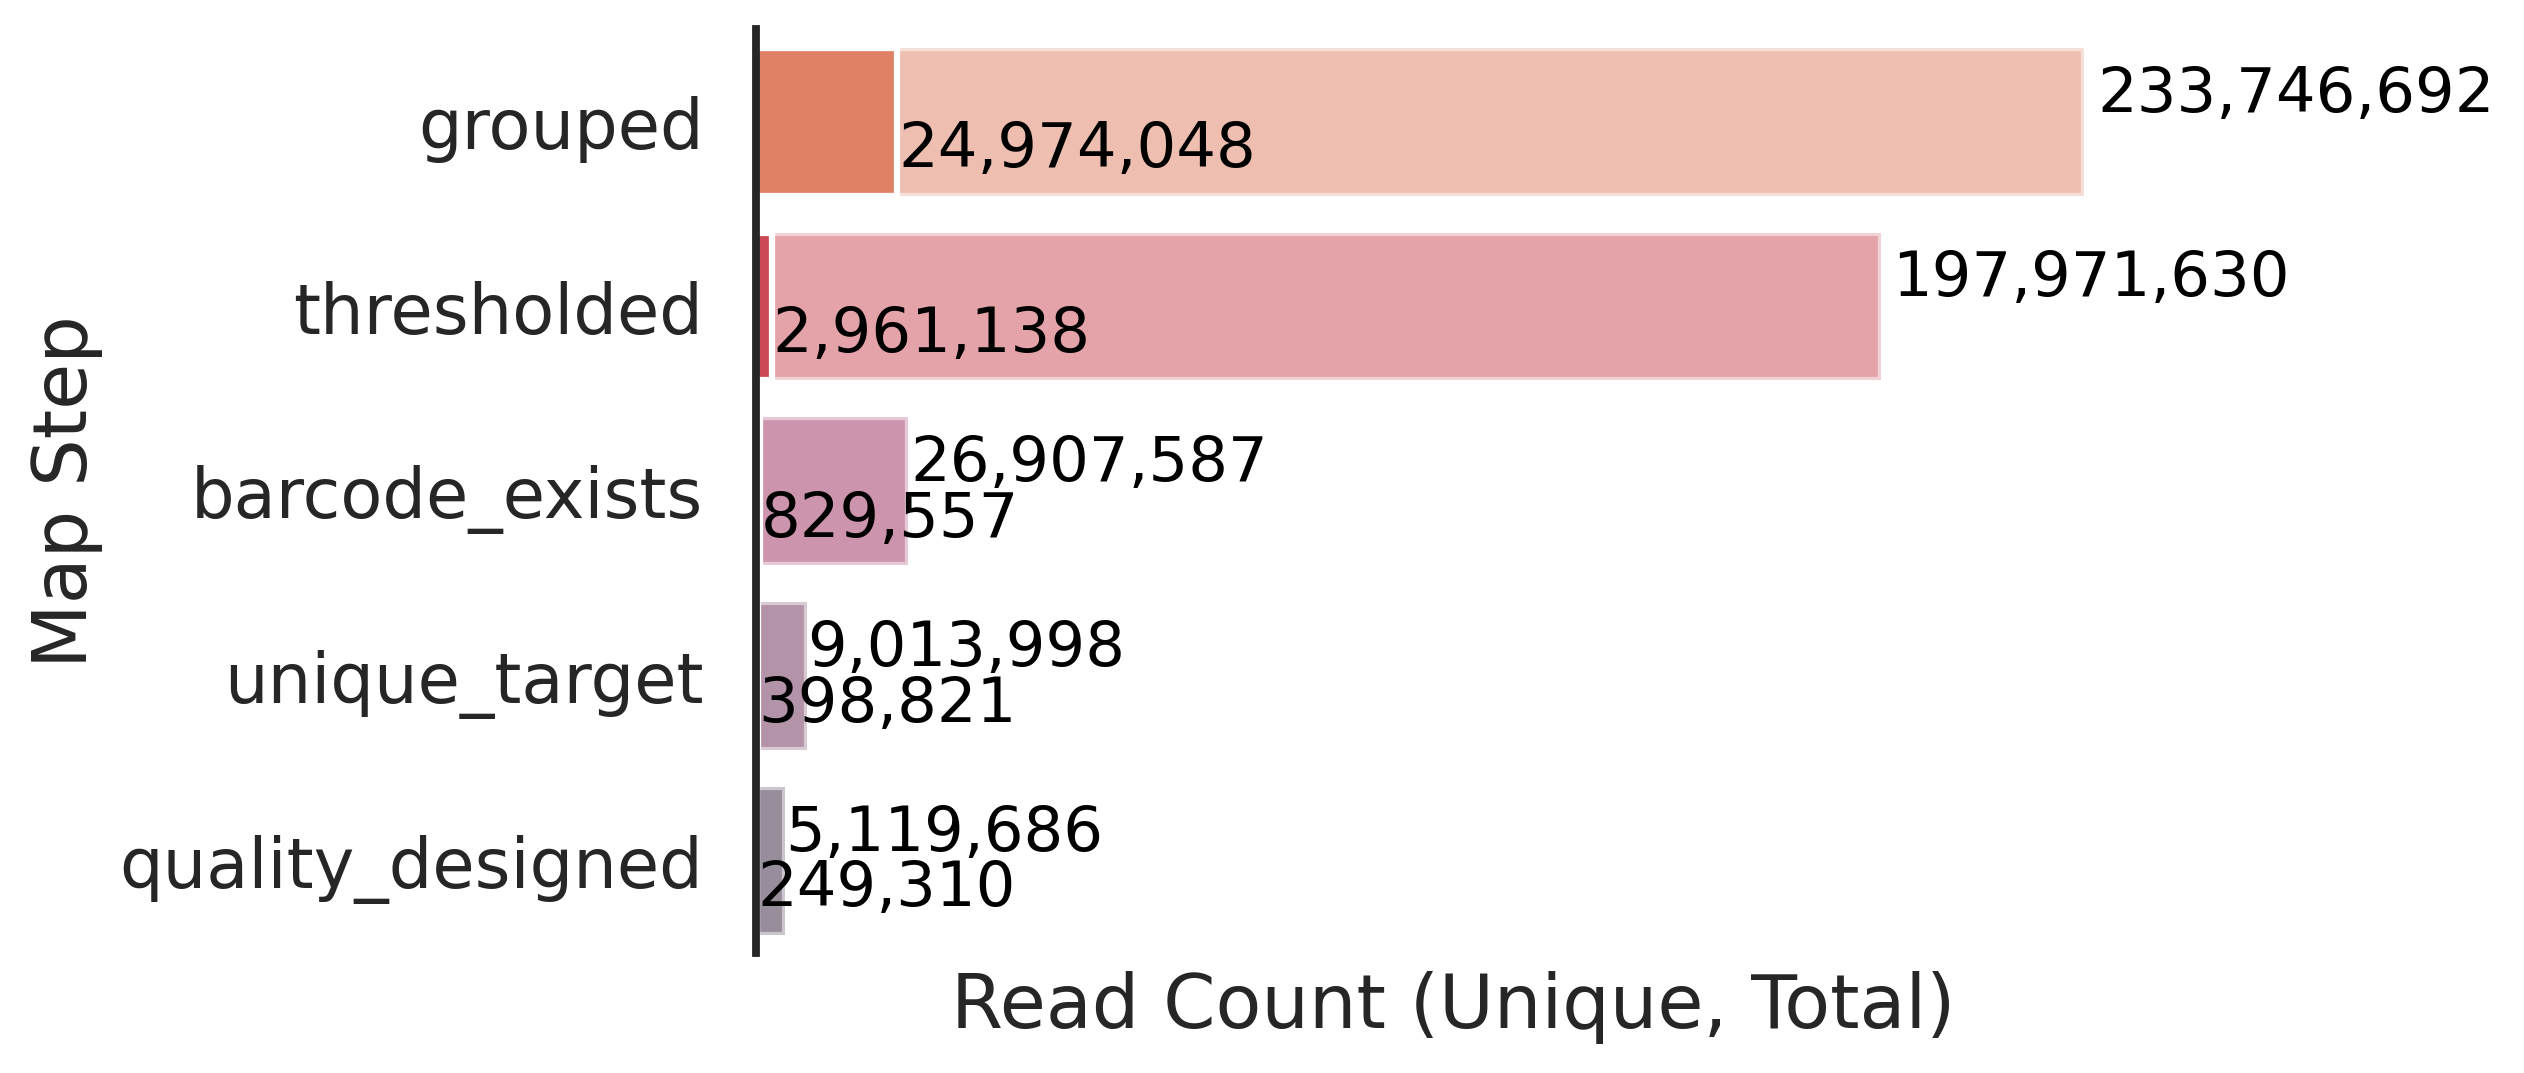

In [23]:
#refiner.save_loss_table()
refiner.plot_loss(text_offset = -0.15)

# Step 2 

Initial maps made at /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/ChopTFs/step1_step2_initial_maps.py

## September 2025 (most recent data, should have most transformants)
data: 

/global/scratch/projects/fc_mvslab/data/sequencing/czb_new_sept2025/MAZ10/ChopTF/results
use _concat files in AD_Assembled and RPTR_Assembled folders


AD: /global/scratch/projects/fc_mvslab/OpenProjects/Marissa/TREBL_Plasmid/2025-08-26_ChopTFstep2/2025-09-29_1.7MColonies/ADscripts/slurm-28477740.out

RPTR: /global/scratch/projects/fc_mvslab/OpenProjects/Marissa/TREBL_Plasmid/2025-08-26_ChopTFstep2/2025-09-29_1.7MColonies/RPTRscripts/slurm-28477741.out

Base prefix (stable across descriptors): step2_new_AD_AD_BC_
Full prefix for this instance: step2_new_AD_AD_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. quality_designed

Grouping step2_new_AD_AD_BC_initial...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

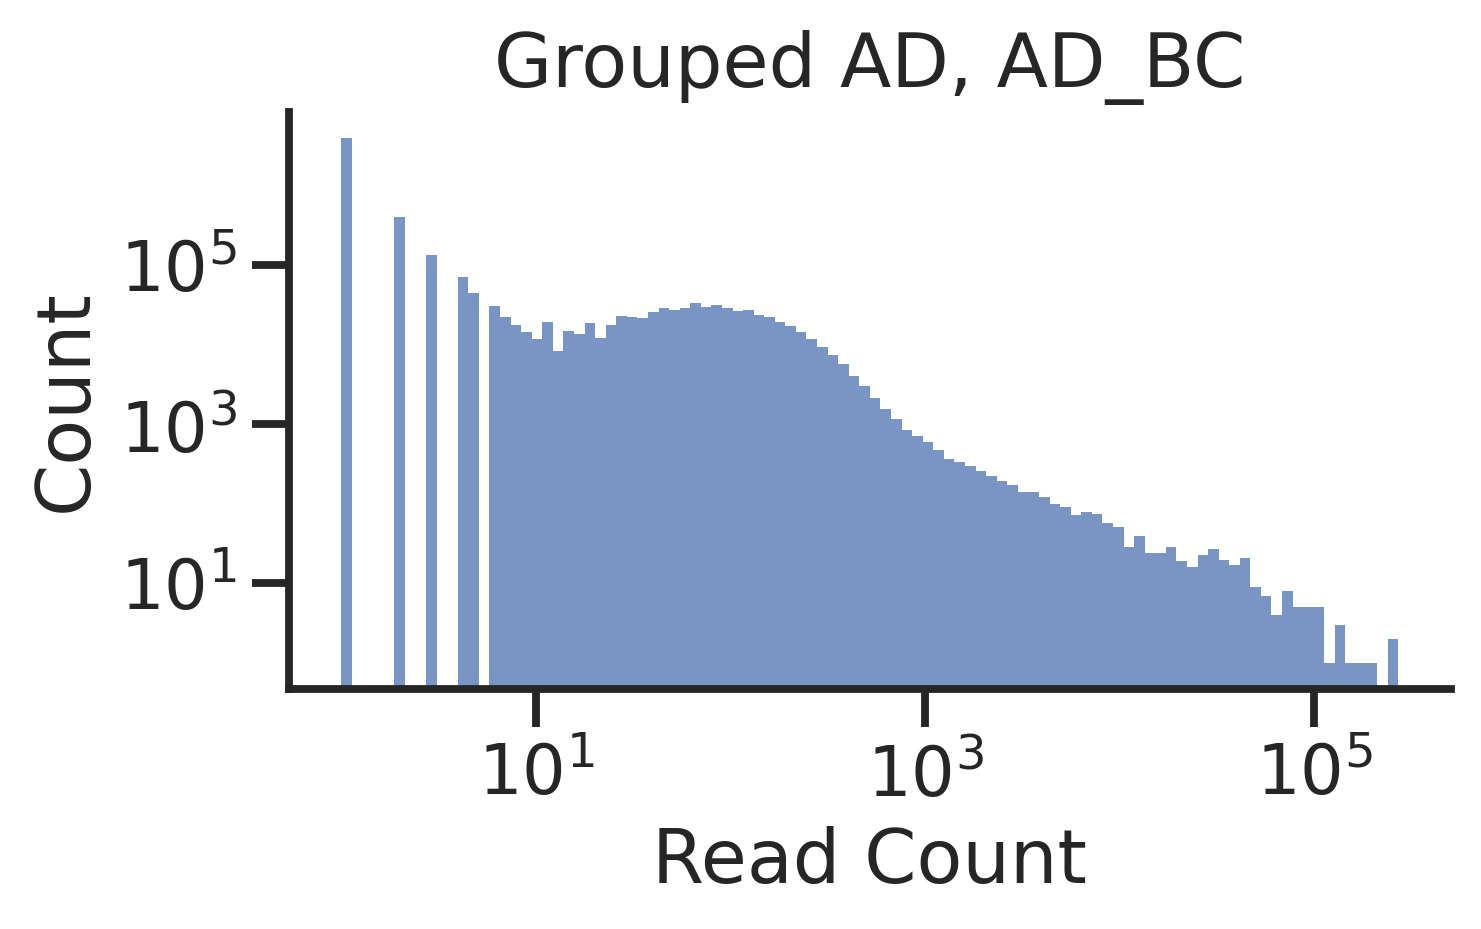

Done in 12.06 seconds.

Thresholding...


Enter minimum read count threshold (default = 5):  10


Using reads threshold of 10.


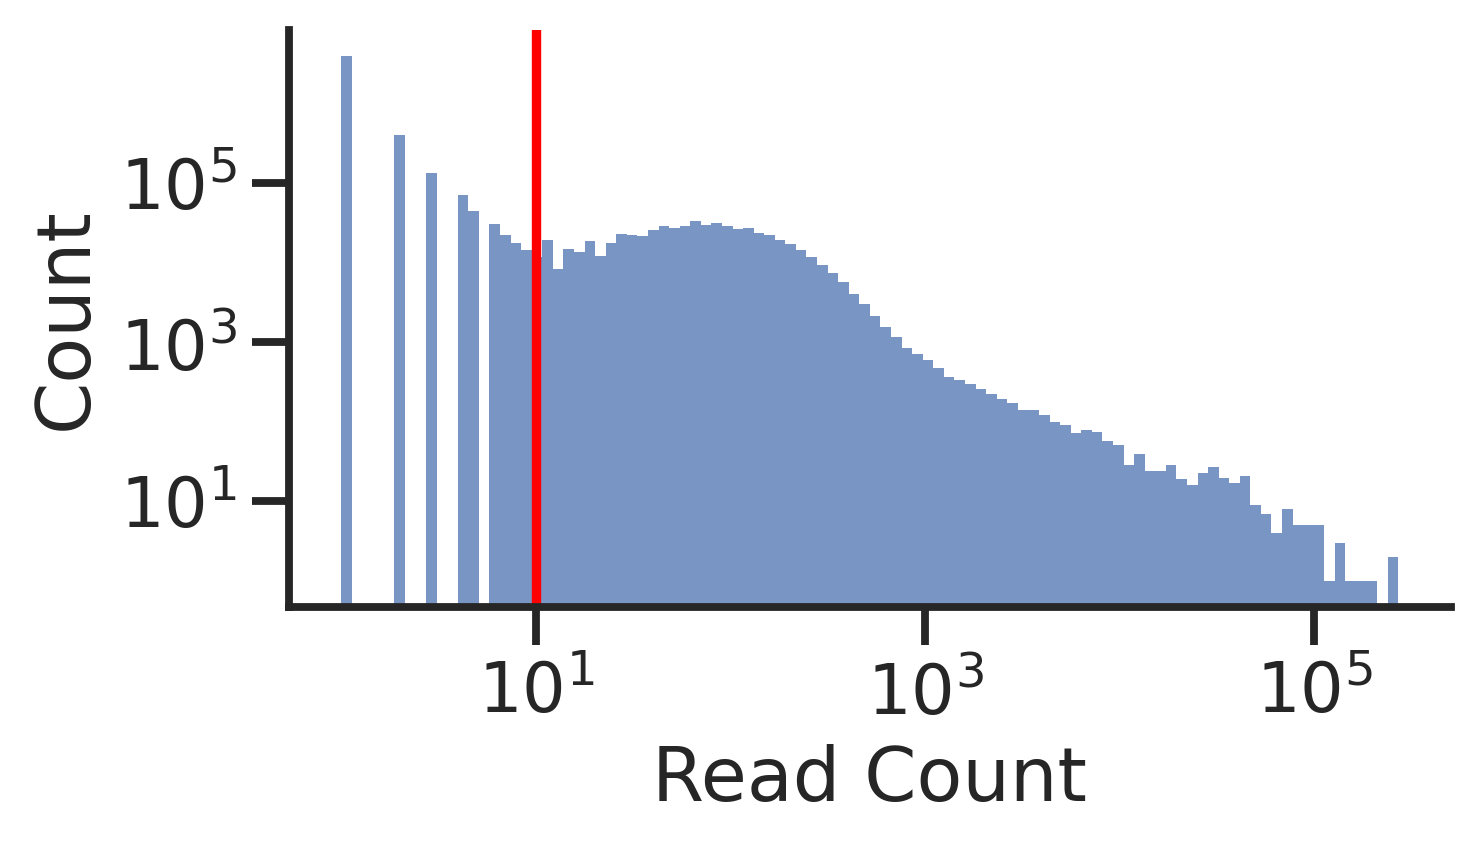

Done in 8.79 seconds.

Filtering to quality and designed...
Done in 0.52 seconds.

Done.
Saved loss summary table as 'step2_new_AD_AD_BC_loss_summary'
Done in 1.12 seconds.



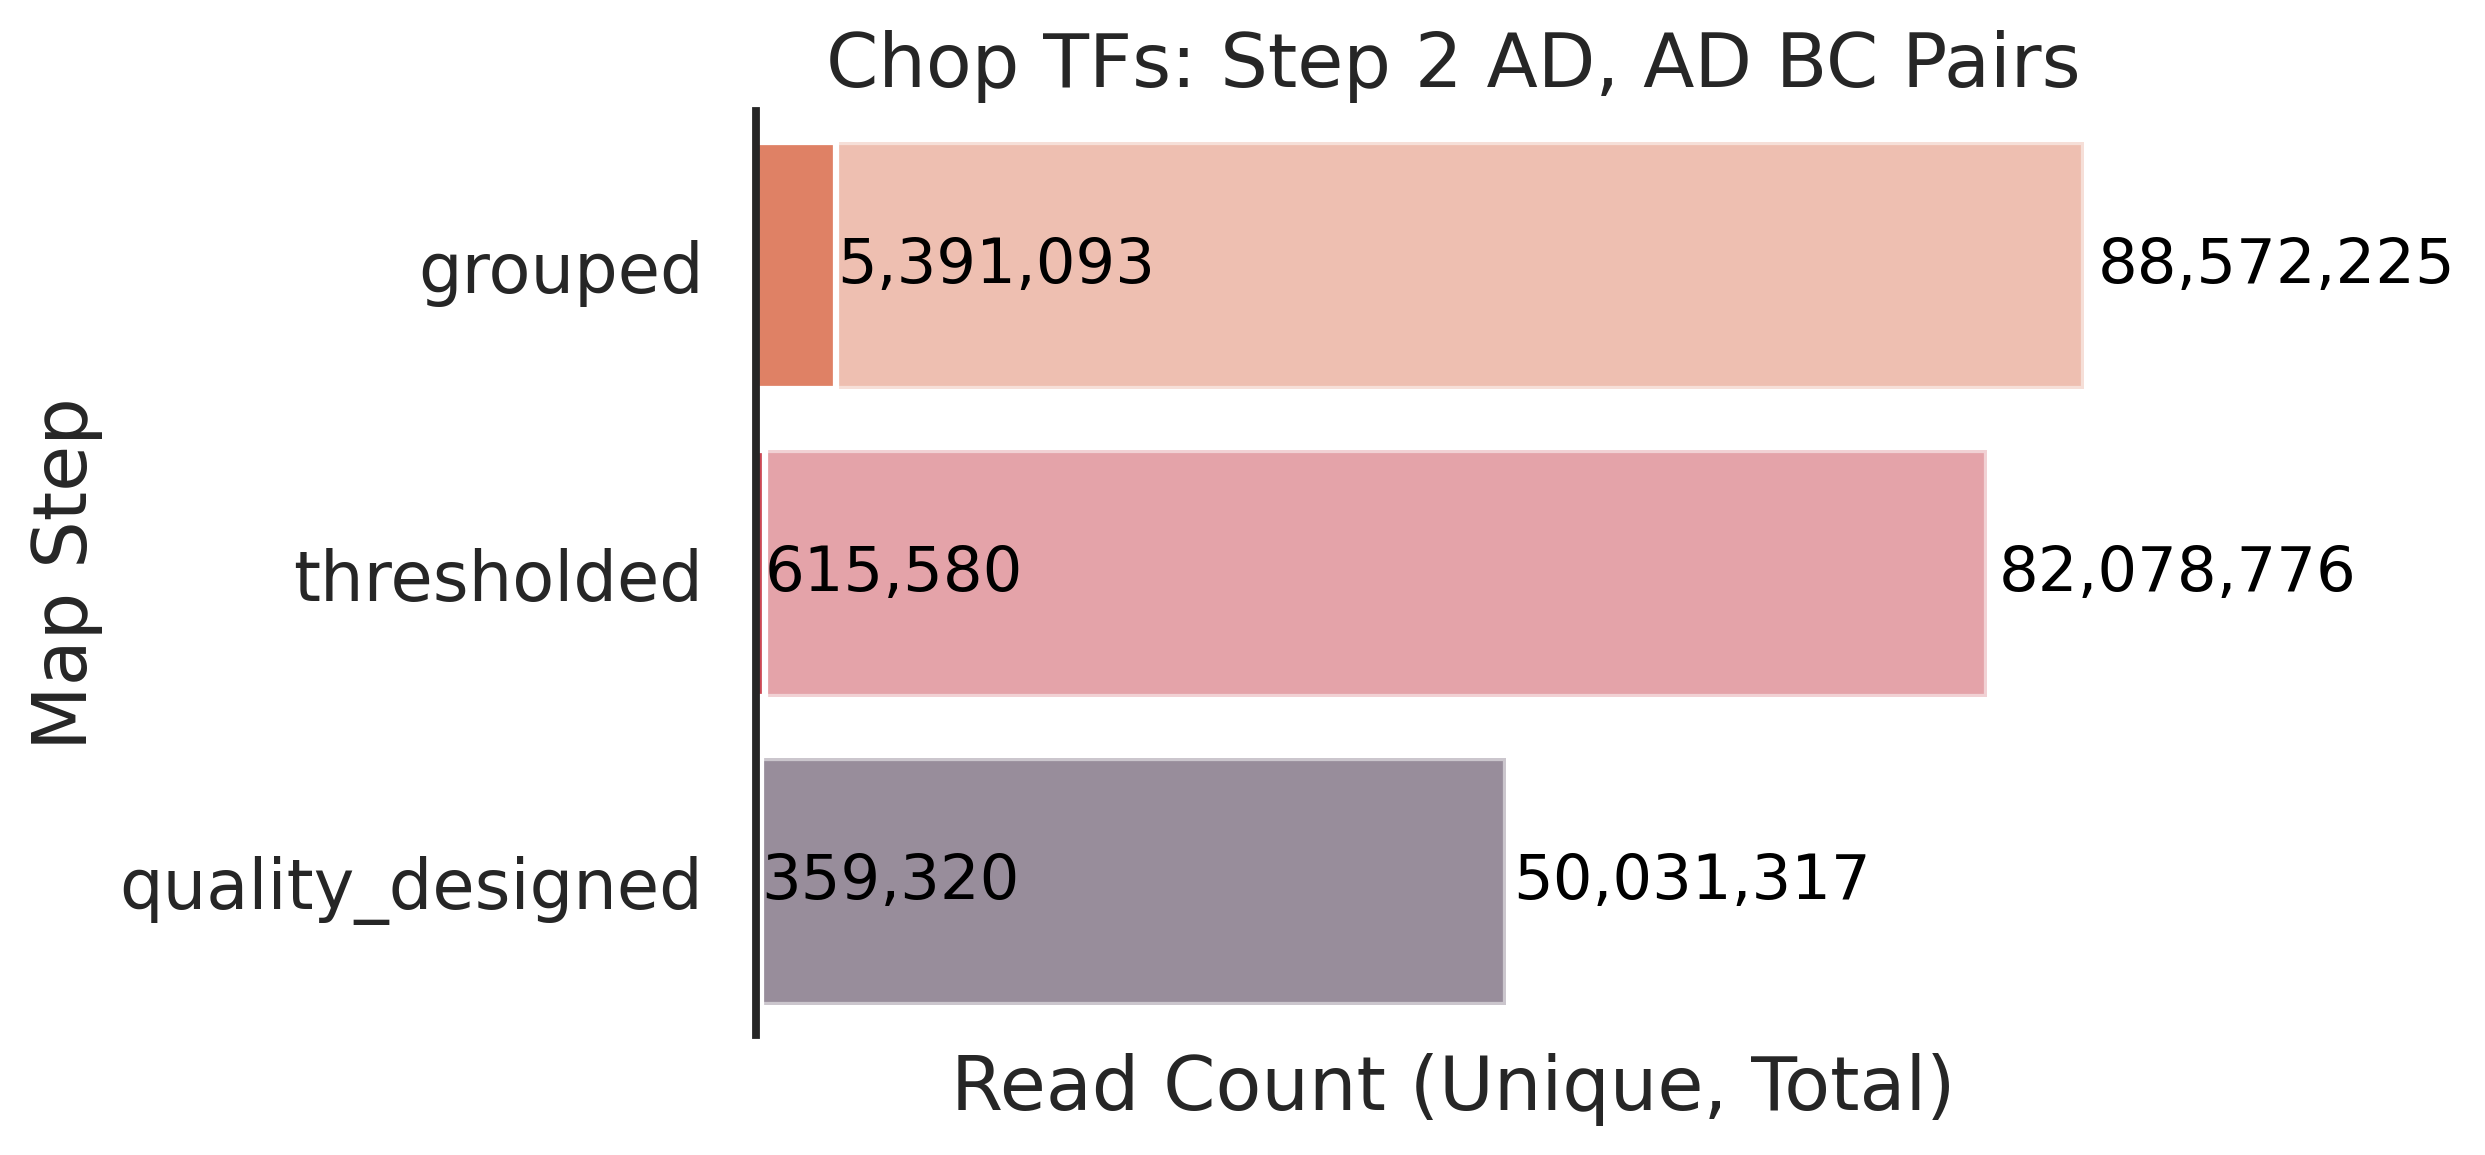

In [27]:
# Refine ADBC map
step2_new_AD_ADBC_refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs.db",
                                                bc_objects=[AD, AD_BC],
                                                column_pairs = [],
                                                design_check = True,
                                                map_order = ['grouped', 'thresholded', 'quality_designed'],
                                                step_name="step2_new",
                                                design_file="/global/scratch/projects/fc_mvslab/OpenProjects/Marissa/DesignFiles/ChopTFDesign.csv", #CHANGE
                                                output_figures_path="../../output/ChopTFs/figures/",
                                                  should_check_exists = False)
step2_new_AD_ADBC_refiner.refine_map_from_db()
ax = step2_new_AD_ADBC_refiner.plot_loss()
plt.title("Chop TFs: Step 2 AD, AD BC Pairs")
plt.show()

Base prefix (stable across descriptors): step2_new_RPTR_BC_
Full prefix for this instance: step2_new_RPTR_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. quality_designed

Grouping step2_new_RPTR_BC_initial...


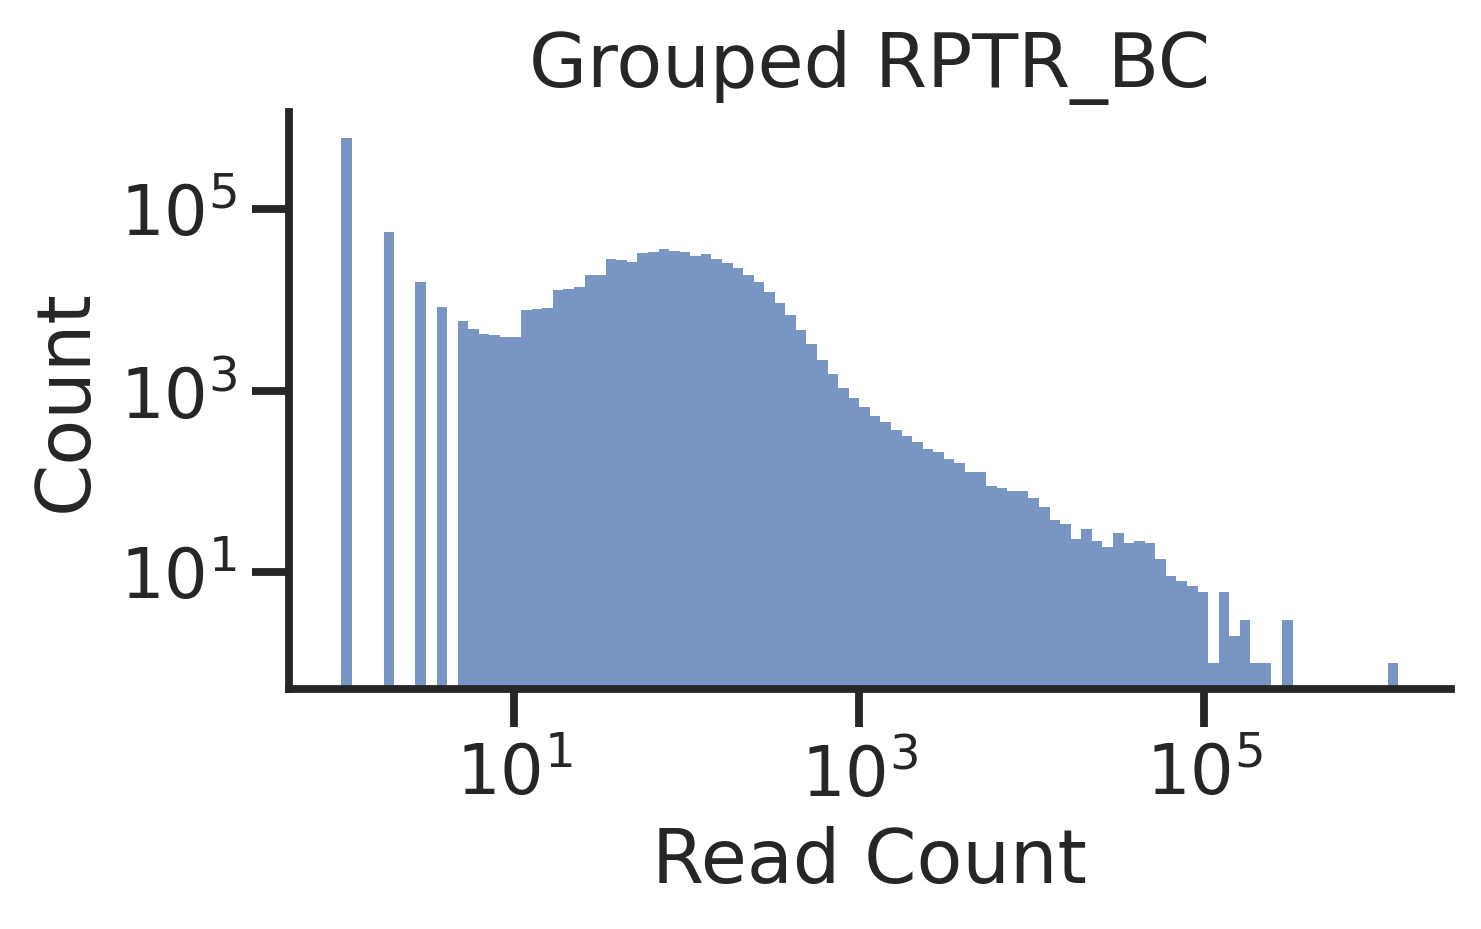

Done in 2.52 seconds.

Thresholding...


Enter minimum read count threshold (default = 5):  10


Using reads threshold of 10.


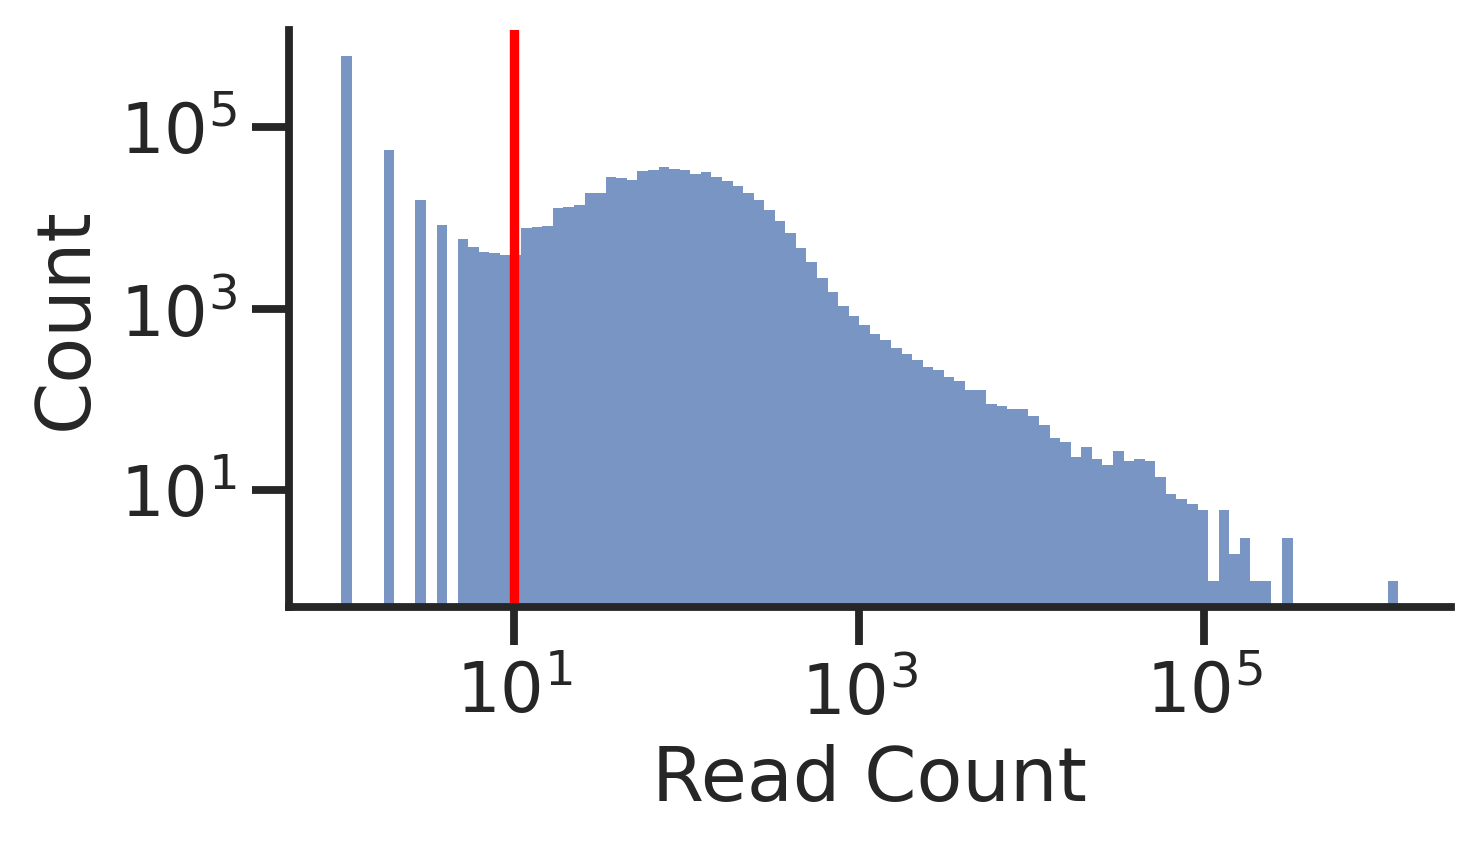

Done in 3.25 seconds.

Filtering to quality and designed...
Done in 0.25 seconds.

Done.
Saved loss summary table as 'step2_new_RPTR_BC_loss_summary'
Done in 0.02 seconds.



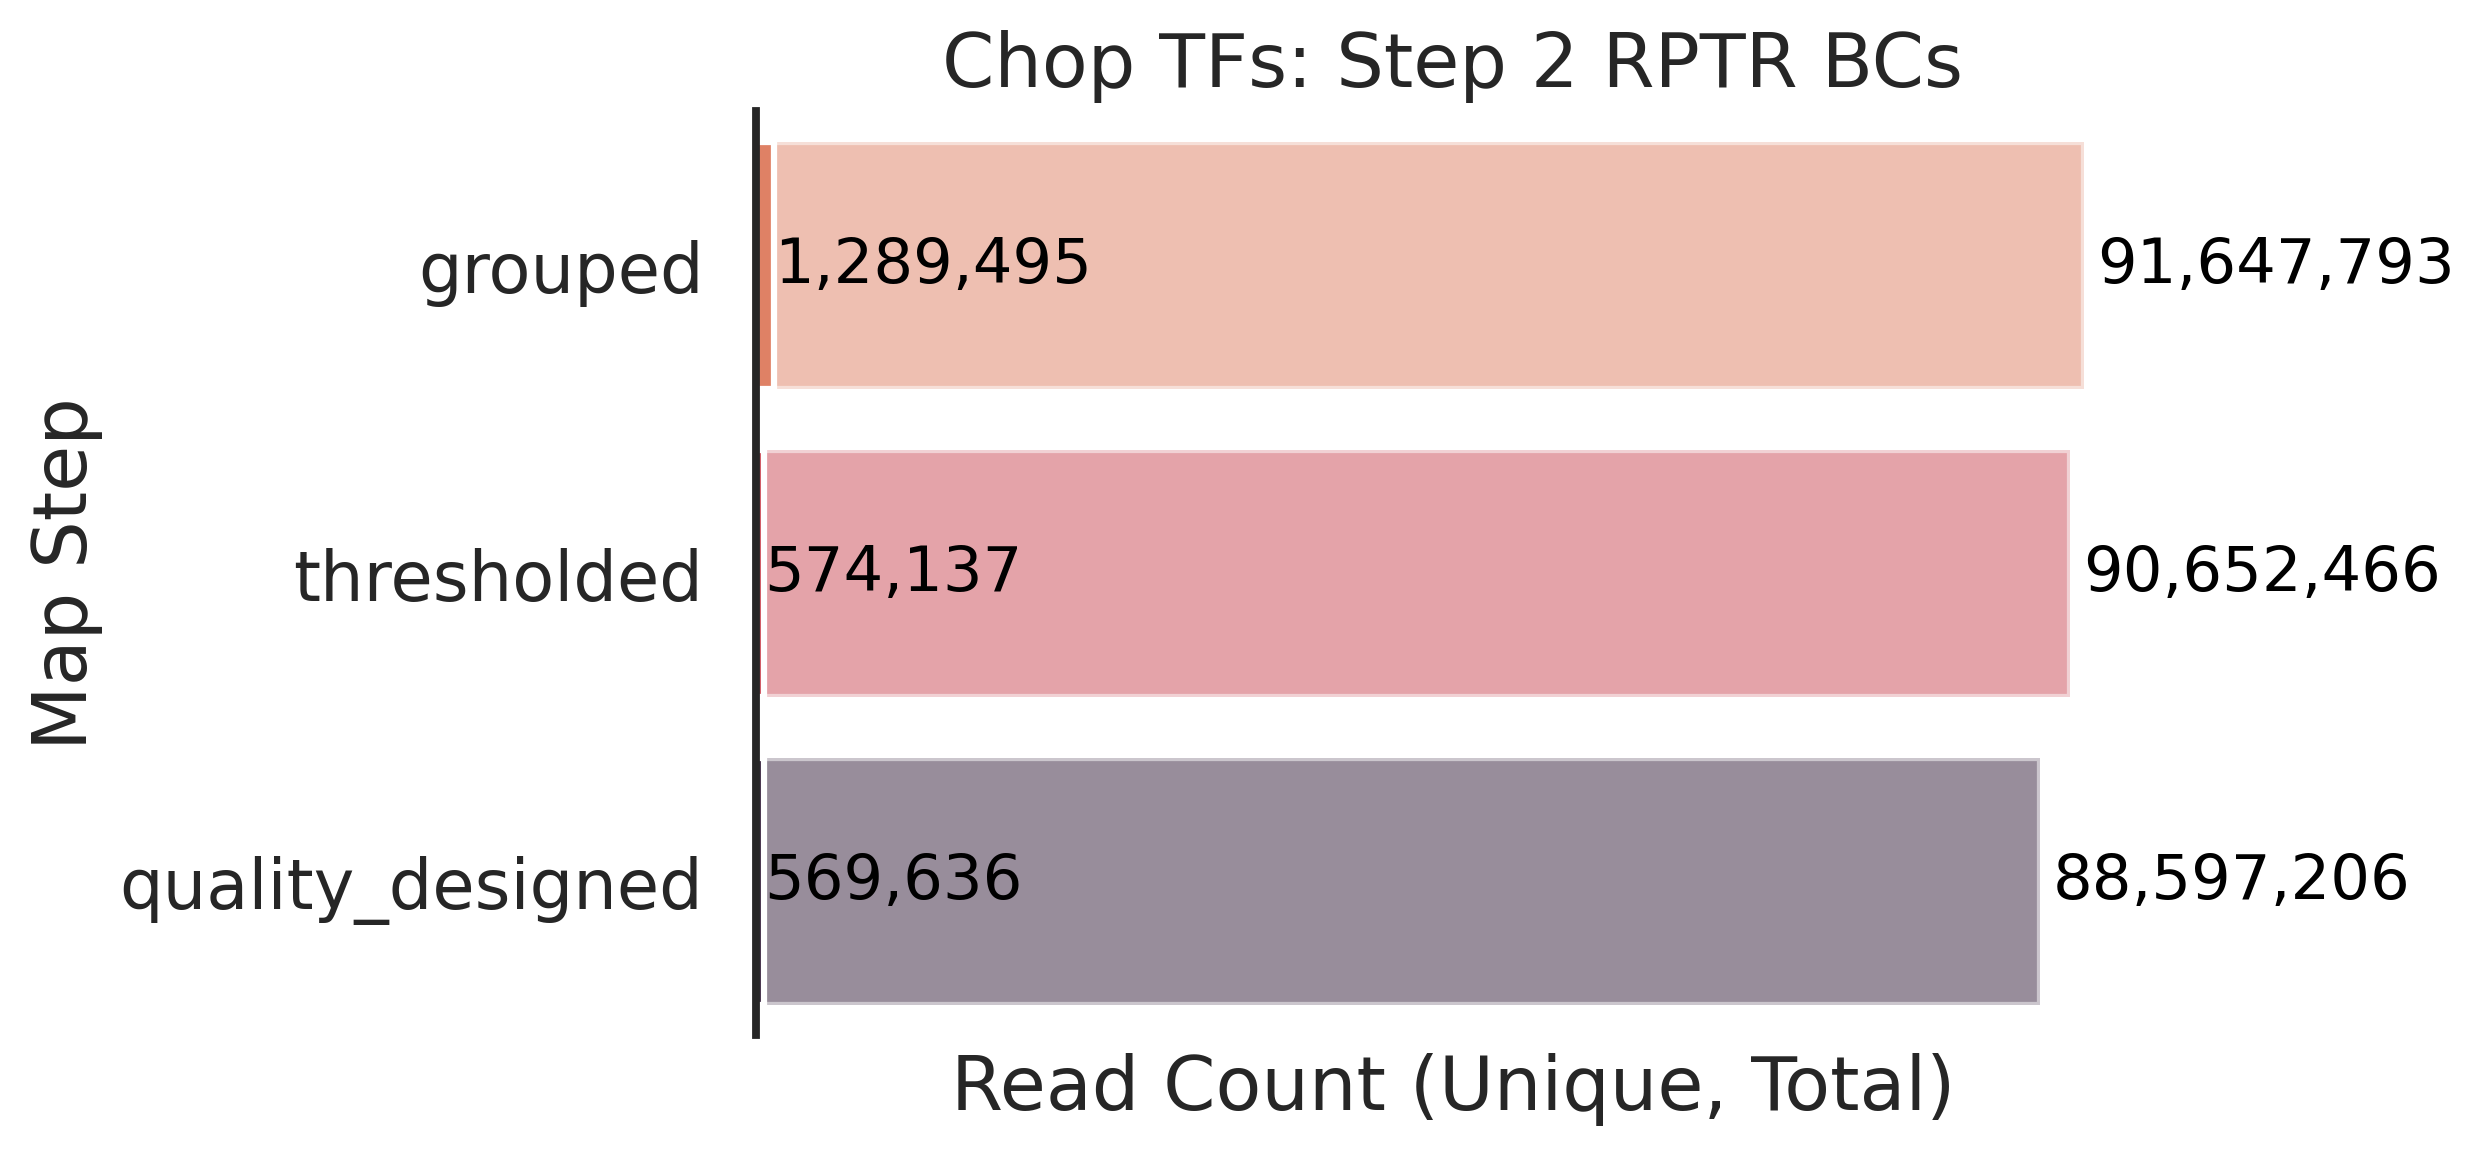

In [40]:
# Refine RTBC map
step2_new_RPTR_refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs.db",
                     bc_objects=[RPTR_BC],
                     column_pairs = [],
                    design_check = False,
                    map_order = ['grouped', 'thresholded', 'quality_designed'],
                    step_name="step2_new",
                       output_figures_path="../../output/ChopTFs/figures/",
                        should_check_exists = False)

step2_new_RPTR_refiner.refine_map_from_db()
ax = step2_new_RPTR_refiner.plot_loss()
plt.title("Chop TFs: Step 2 RPTR BCs")
plt.show()

In [41]:
complexity_checker = complexity.ComplexityChecker(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs.db",
                                                  step_name = "step2_new",
                                                  step1_map_name = "step1_AD_AD_BC_RPTR_BC_quality_designed", #Reads threshold of 100, RPTR BC vs AD key/target check",
                                                  step_suffix = "quality_designed",
                                                  barcode_groups = [(AD, AD_BC), (RPTR_BC)])
complexity_checker.count_overlap()

,BC_type,map_unique,step2_new,seen_in_both,percent_of_map_seen
0,"AD,AD_BC",249257,359320,162581,65.226
1,RPTR_BC,248892,569636,163995,65.890


## June 2025 (not enough transformants)

data: /global/scratch/projects/fc_mvslab/data/sequencing/CZB_Jun2025/MAZ07/MZ_AU_SCU/results

AD output: /global/scratch/projects/fc_mvslab/OpenProjects/Marissa/TREBL_Plasmid/2025-08-26_ChopTFstep2/ECAnalysis/ADscripts/slurm-27653931.out

RPTR output: /global/scratch/projects/fc_mvslab/OpenProjects/Marissa/TREBL_Plasmid/2025-08-26_ChopTFstep2/ECAnalysis/RPTRscripts/slurm-27654482.out (tile-BC-BC counts based on Emily's code = 18,885; I was expecting around 113,000)


Base prefix (stable across descriptors): step2_old_AD_AD_BC_
Full prefix for this instance: step2_old_AD_AD_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. quality_designed

Grouping step2_old_AD_AD_BC_initial...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

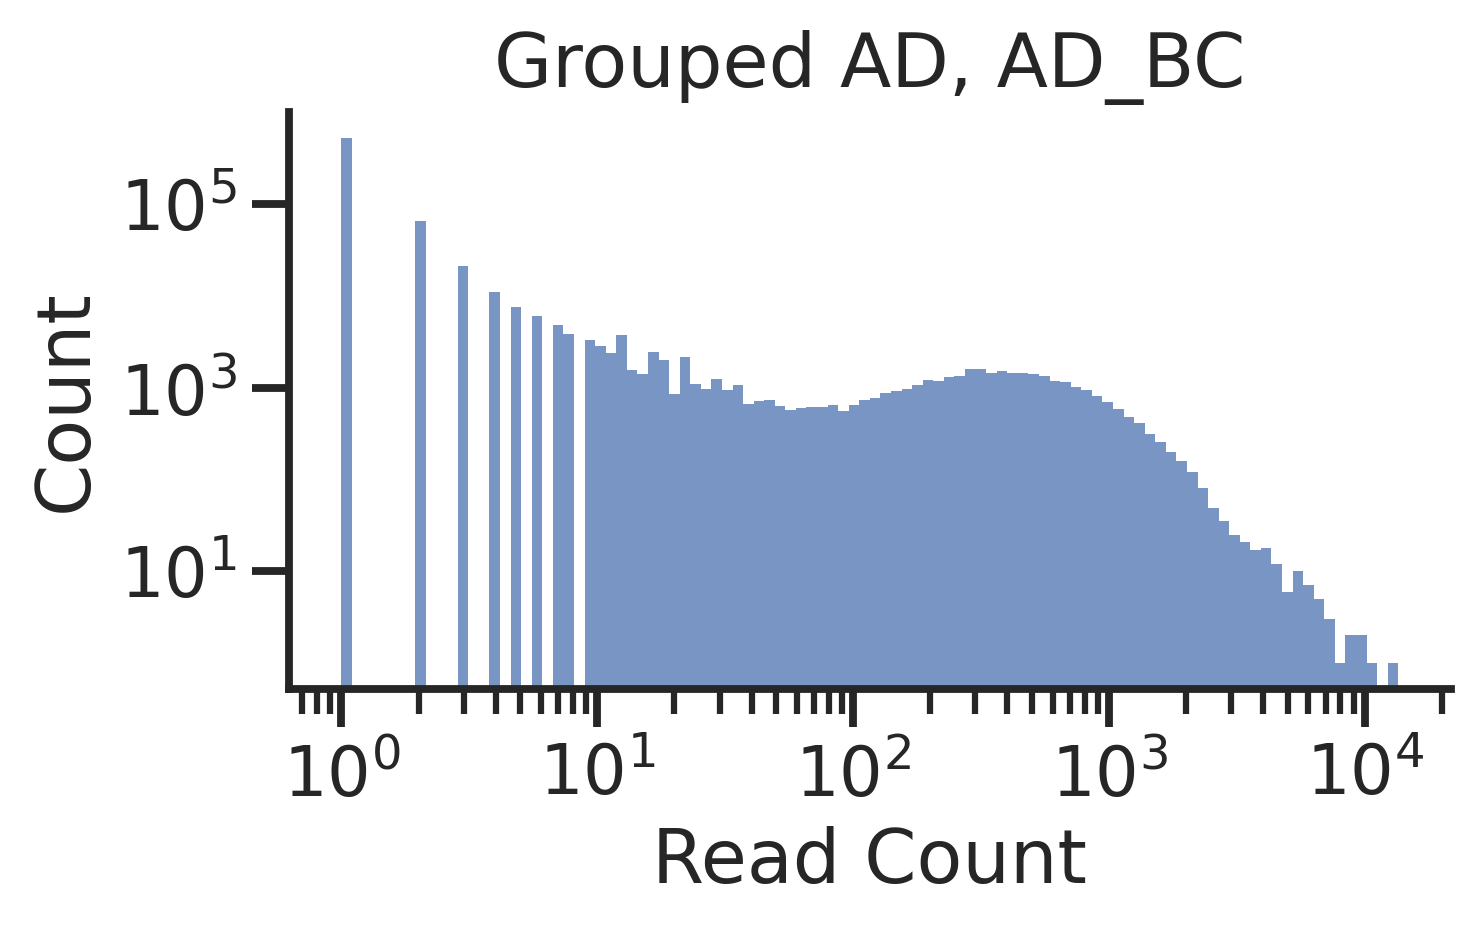

Done in 3.78 seconds.

Thresholding...


Enter minimum read count threshold (default = 5):  50


Using reads threshold of 50.


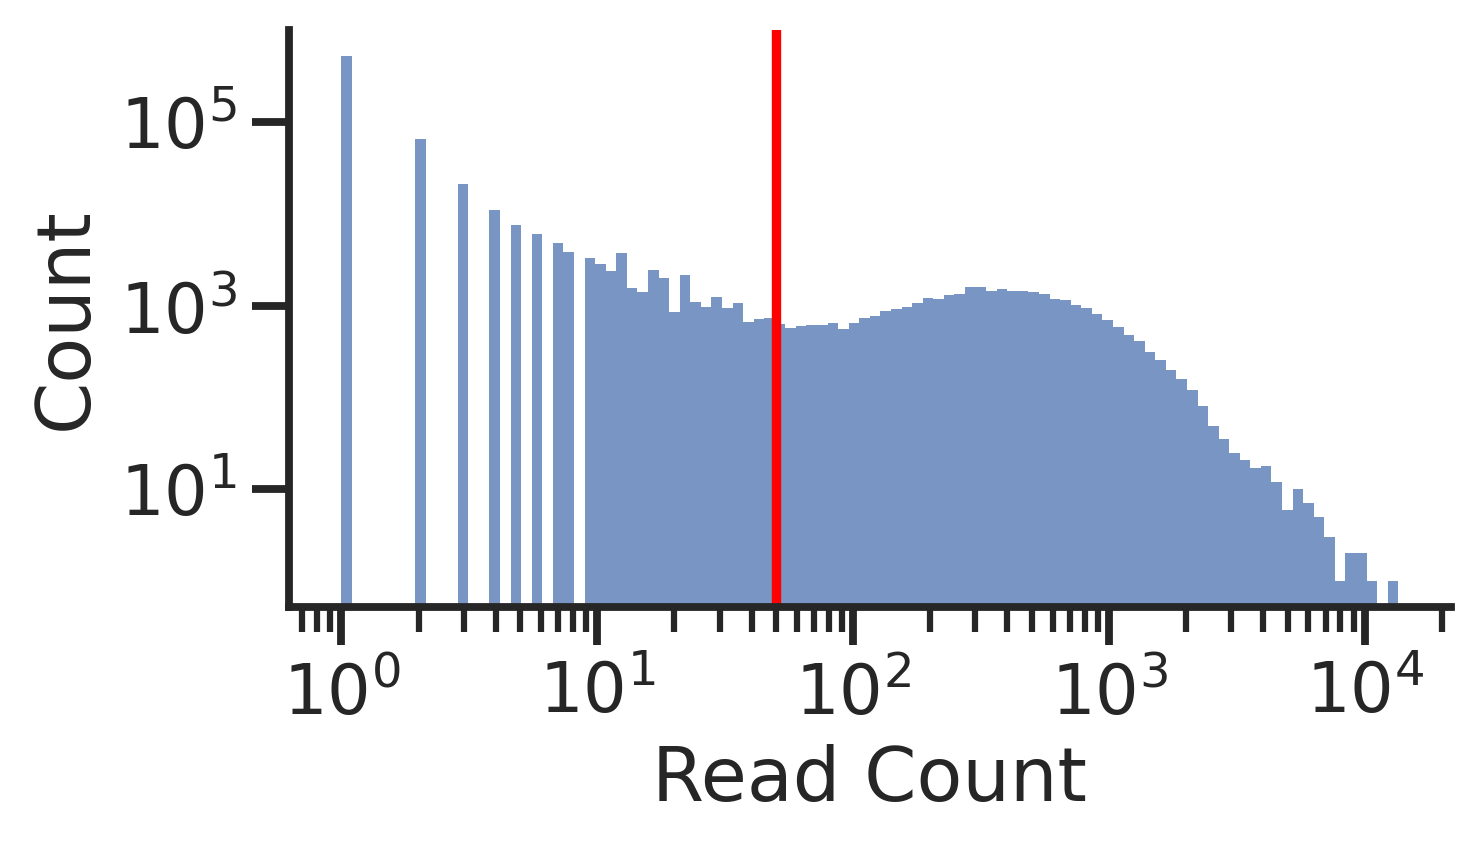

Done in 8.46 seconds.

Filtering to quality and designed...
Done in 0.03 seconds.

Done.
Saved loss summary table as 'step2_old_AD_AD_BC_loss_summary'
Done in 0.22 seconds.



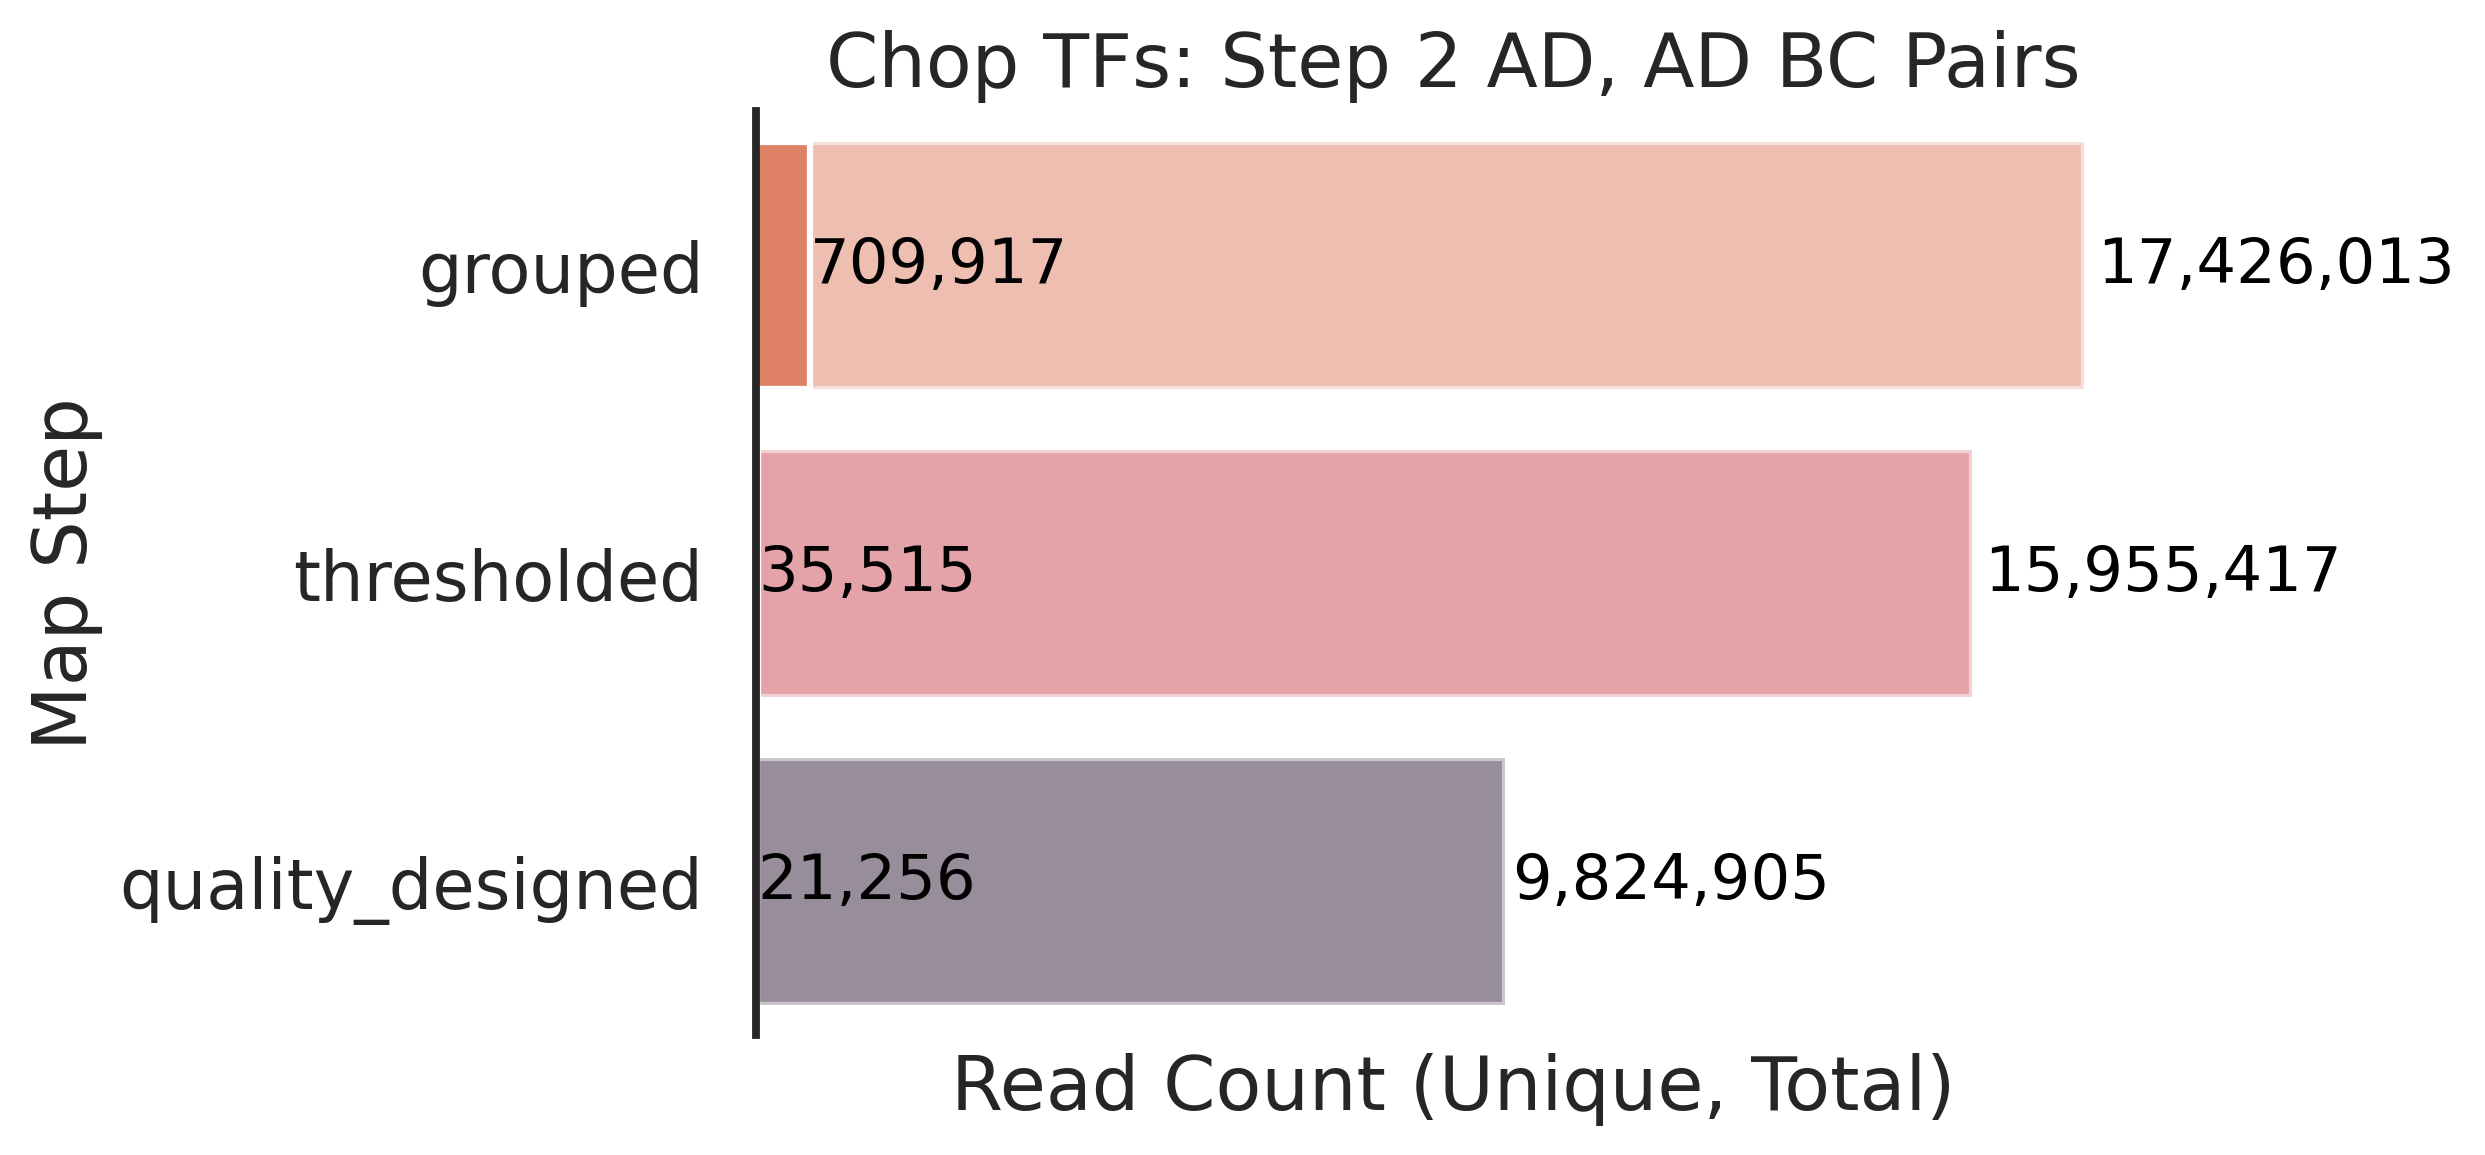

In [31]:
# Refine ADBC map
step2_old_AD_ADBC_mapper = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs.db",
                                                bc_objects=[AD, AD_BC],
                                                column_pairs = [],
                                                design_check = True,
                                                map_order = ['grouped', 'thresholded', 'quality_designed'],
                                                step_name="step2_old",
                                                  should_check_exists = False,
                                                design_file="/global/scratch/projects/fc_mvslab/OpenProjects/Marissa/DesignFiles/ChopTFDesign.csv",
                                                output_figures_path="../../output/ChopTFs/figures/")
step2_old_AD_ADBC_mapper.refine_map_from_db()
ax = step2_old_AD_ADBC_mapper.plot_loss()
plt.title("Chop TFs: Step 2 AD, AD BC Pairs")
plt.show()

Base prefix (stable across descriptors): step2_old_RPTR_BC_
Full prefix for this instance: step2_old_RPTR_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. quality_designed

Grouping step2_old_RPTR_BC_initial...


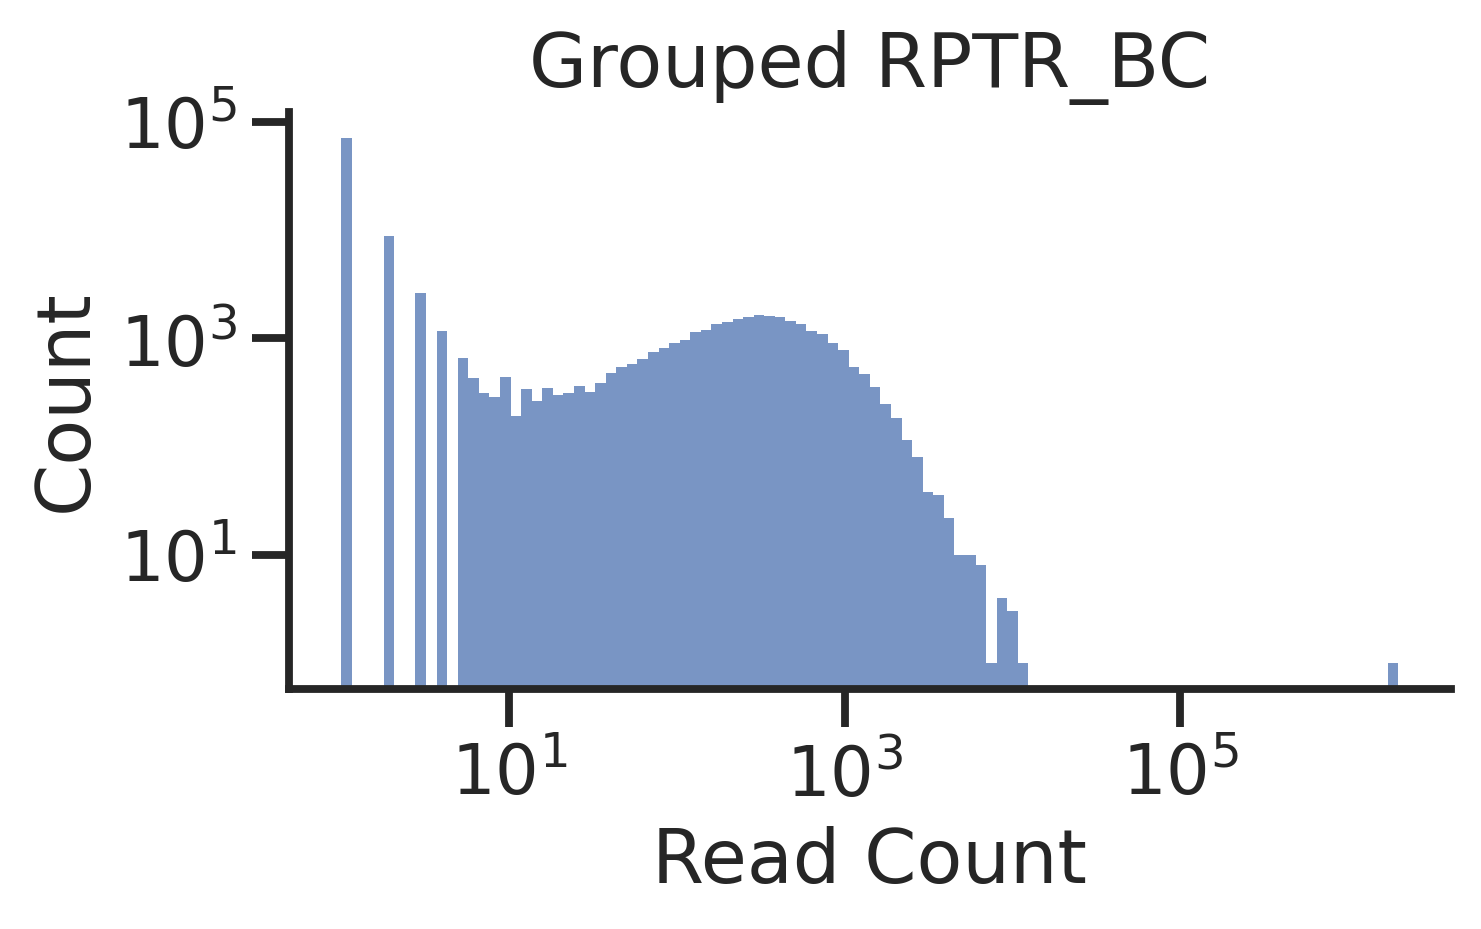

Done in 0.56 seconds.

Thresholding...


Enter minimum read count threshold (default = 5):  15


Using reads threshold of 15.


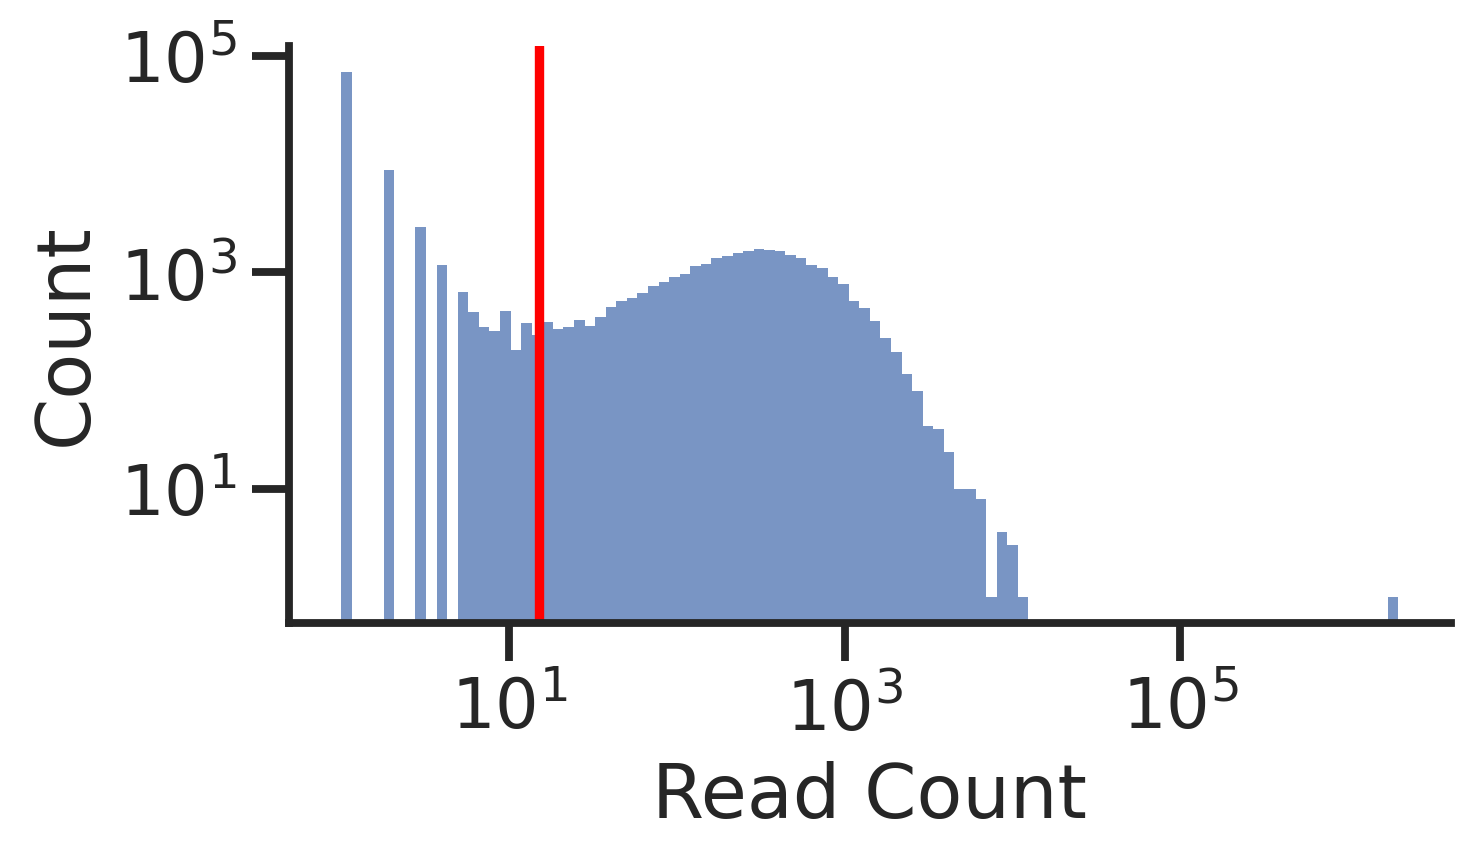

Done in 2.36 seconds.

Filtering to quality and designed...
Done in 0.01 seconds.

Done.
Saved loss summary table as 'step2_old_RPTR_BC_loss_summary'
Done in 0.02 seconds.



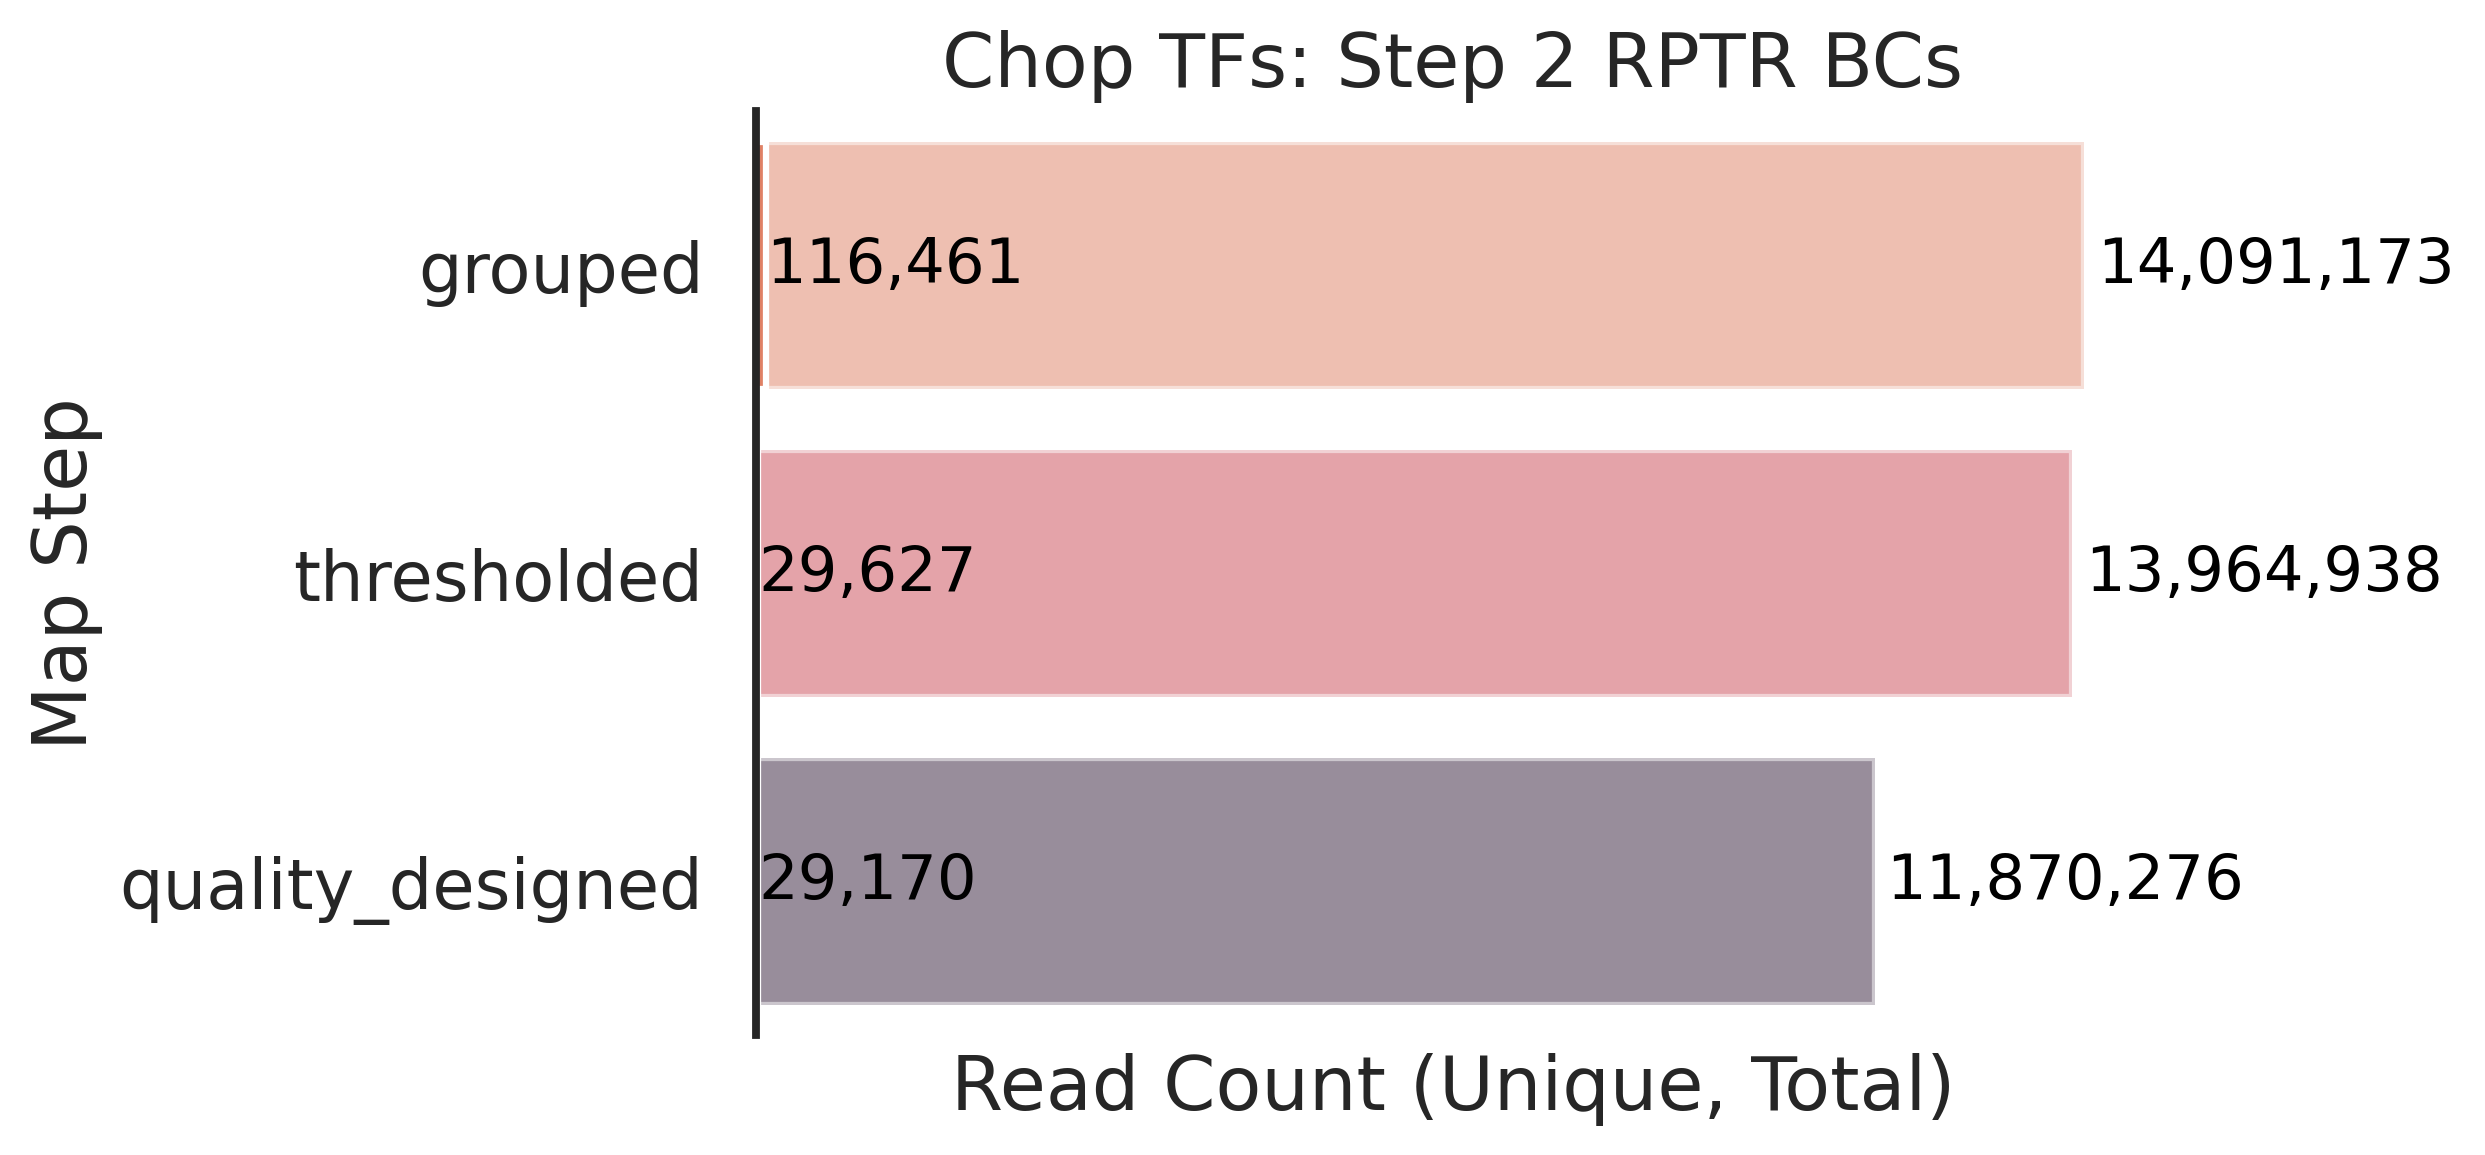

In [35]:
# Refine RTBC map
step2_old_RPTR_refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs.db",
                     bc_objects=[RPTR_BC],
                     column_pairs = [],
                    design_check = False,
                    map_order = ['grouped', 'thresholded', 'quality_designed'],
                                                                step_name="step2_old",
                                                  should_check_exists = False,
                       output_figures_path="../../output/ChopTFs/figures/")

step2_old_RPTR_refiner.refine_map_from_db()
ax = step2_old_RPTR_refiner.plot_loss()
plt.title("Chop TFs: Step 2 RPTR BCs")
plt.show()

In [36]:
complexity_checker = complexity.ComplexityChecker(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs.db",
                                                  step_name = "step2_old",
                                                  step1_map_name = "step1_AD_AD_BC_RPTR_BC_quality_designed", #Reads threshold of 100, RPTR BC vs AD key/target check",
                                                  step_suffix = "quality_designed",
                                                  barcode_groups = [(AD, AD_BC), (RPTR_BC)])
complexity_checker.count_overlap()

,BC_type,map_unique,step2_old,seen_in_both,percent_of_map_seen
0,"AD,AD_BC",249257,21256,8762,3.515
1,RPTR_BC,248892,29170,7570,3.041


# [TO-DO] What is the difference between old and new step 2?

In [74]:
step2_new_AD_ADBC_refiner_map = step2_new_AD_ADBC_refiner.get_map_df('quality_designed')
step2_new_AD_ADBC_refiner_map

,AD,AD_BC,count,AD_qual,AD_BC_qual,Designed
0,TATACTCCAGAAAGAGGTTCTGCTAATAGAGCTAGATCTCCATTGC...,CAGTTTAGCTA,248077,True,True,1
1,GGTTCTGCTAATAGAGCTAGATCTCCATTGCATTCTAATTCTAATA...,ACGGTCGTGAA,178377,True,True,1
2,GGTTCTGCTAATAGAGCTAGATCTCCATTGCATTCTAATTCTAATA...,TTGAACACAGA,155812,True,True,1
3,AATACTCCAGCTAATGTTATTGCTACTGATGCTACTAAATATGAAA...,TGTCCTTGTCG,134479,True,True,1
4,GCTAGATCTCCATTGCATTCTAATTCTAATAATACTAATAATAATG...,TTTGTGTACAT,128127,True,True,1
...,...,...,...,...,...,...
359315,CCATTTCCATTGAGATTCTCATTTGCTCAAAGAGCTAAGATTGAAA...,TAGTCAGCGGT,11,True,True,1
359316,GTTGGTATTTCTCAACATTTGCCATCTCAACAACAACAAAGAGCTA...,ATCTATTAATA,11,True,True,1
359317,TTCTCTAATGCATTTGAATCTAATACTGCTCAGAATGTTTCTATGT...,ATTATGGTCAG,11,True,True,1
359318,ACTTCTTGCTTTGAACCTAAGAATAATTTGCCATCTTTGTCATTCT...,TTTATTCACAA,11,True,True,1


In [76]:
step2_old_AD_ADBC_refiner_map = step2_old_AD_ADBC_mapper.get_map_df('quality_designed')
step2_old_AD_ADBC_refiner_map

,AD,AD_BC,count,AD_qual,AD_BC_qual,Designed
0,GGTTCTGCTAATAGAGCTAGATCTCCATTGCATTCTAATTCTAATA...,AACGTGAGAAC,9980,True,True,1
1,ACTGCTATGGAAGCTTATACTCCAGAAAGAGGTTCTGCTAATAGAG...,GCAGTTTACGG,9066,True,True,1
2,ACTGCTATGGAAGCTTATACTCCAGAAAGAGGTTCTGCTAATAGAG...,ACTTCACTCTC,8686,True,True,1
3,AATACTCCAGCTAATGTTATTGCTACTGATGCTACTAAATATGAAA...,ACCCCCGCTAT,8225,True,True,1
4,GCTAGATCTCCATTGCATTCTAATTCTAATAATACTAATAATAATG...,ACAAATTAGTC,6536,True,True,1
...,...,...,...,...,...,...
21251,ACTCCAGGTGGTACTTTGGAAACTCAAATTTCTCCAAGGAAATCTT...,AAATATATCGA,51,True,True,1
21252,TCTGAATCTCAATCTCAGAATAAATTTGATTATGATATGTTCTTTA...,CCGTATATAAA,51,True,True,1
21253,AAGAAGAATATTGATATTGATTTGGGTCCAGCTAAGATTGTTTCTA...,TCTCATCTACA,51,True,True,1
21254,CCATCTTGTACTGCTTGTTTGAAAGCTGGTATTAAATGTGTTCAAC...,AGCTGAAGAAA,51,True,True,1


In [82]:
# 17,000 of old step 2 is seen in new step 2
step2_AD_AD_BC_new_old = pd.merge(step2_old_AD_ADBC_refiner_map, step2_new_AD_ADBC_refiner_map, on = ["AD", "AD_BC"])
step2_AD_AD_BC_new_old

,AD,AD_BC,count_x,AD_qual_x,AD_BC_qual_x,Designed_x,count_y,AD_qual_y,AD_BC_qual_y,Designed_y
0,GGTTCTGCTAATAGAGCTAGATCTCCATTGCATTCTAATTCTAATA...,AACGTGAGAAC,9980,True,True,1,63501,True,True,1
1,ACTGCTATGGAAGCTTATACTCCAGAAAGAGGTTCTGCTAATAGAG...,GCAGTTTACGG,9066,True,True,1,98511,True,True,1
2,ACTGCTATGGAAGCTTATACTCCAGAAAGAGGTTCTGCTAATAGAG...,ACTTCACTCTC,8686,True,True,1,42229,True,True,1
3,AATACTCCAGCTAATGTTATTGCTACTGATGCTACTAAATATGAAA...,ACCCCCGCTAT,8225,True,True,1,49438,True,True,1
4,GCTAGATCTCCATTGCATTCTAATTCTAATAATACTAATAATAATG...,ACAAATTAGTC,6536,True,True,1,35563,True,True,1
...,...,...,...,...,...,...,...,...,...,...
17315,CCAAGGAAACAAGATCAATTGTGTAATTCTTGTGGTTTGAGATATA...,ATTTCAATCTC,51,True,True,1,61,True,True,1
17316,ACTCCAGGTGGTACTTTGGAAACTCAAATTTCTCCAAGGAAATCTT...,AAATATATCGA,51,True,True,1,112,True,True,1
17317,TCTGAATCTCAATCTCAGAATAAATTTGATTATGATATGTTCTTTA...,CCGTATATAAA,51,True,True,1,43,True,True,1
17318,AAGAAGAATATTGATATTGATTTGGGTCCAGCTAAGATTGTTTCTA...,TCTCATCTACA,51,True,True,1,104,True,True,1


In [83]:
step1 = refiner.get_map_df('quality_designed')
step1

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed
0,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1
1,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,ACCAAGGTACT,CAGTAGGCTAGTAA,441,True,True,True,1
2,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,TGATAGAGCGA,GTCAATGCTATACA,309,True,True,True,1
3,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,AGCCGAGTAGA,AATCAGCTGTTGAT,276,True,True,True,1
4,ACTGATGCTATTGATGAAGAAGTTGCTATGTCTGCTGTTATTGAAA...,CCTTTGATTAT,GCTTATAGGTGCGG,252,True,True,True,1
...,...,...,...,...,...,...,...,...
249305,GATTCTACTTCTCCAATTAAATATGAAGCTGATGTTTCTGCTGGTG...,TTTTGCTTTTG,AATAGGCAATCATT,18,True,True,True,1
249306,AAAGCTTATCCTAAAGGTTATACTGAATCTTTGGAAGAAAGAGTTA...,ACGGATCTGAG,CACGAAAACTATAC,18,True,True,True,1
249307,GAGAATGGTAAATGTGGTAAAGCTCCATTGTGGTATAGAGTTAAGA...,GTTCTCCCCCC,TCCTAAGTCGGACC,18,True,True,True,1
249308,GATTATGCTAATGATCCAGAATTGAATAATGTTAATGCTAGAGGTT...,AGATCAACAAC,AATGAGAATAATGA,18,True,True,True,1


In [84]:
step1_step2_AD_AD_BC_new_old = pd.merge(step1, step2_AD_AD_BC_new_old, on = ["AD", "AD_BC"])
step1_step2_AD_AD_BC_new_old

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,count_x,AD_qual_x,AD_BC_qual_x,Designed_x,count_y,AD_qual_y,AD_BC_qual_y,Designed_y
0,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,52,True,True,1,3494,True,True,1
1,TATGCTATTCCAGAGAATGAATTGTTGGATGAAGATACTATGAACT...,TAGTGGTATCC,TATCCGACAGTATC,216,True,True,True,1,279,True,True,1,1353,True,True,1
2,GCTGCTATTCCAGAGAATGAATTGTTGGATGAAGATACTATGAATG...,AACGGTTTTCA,TCCTGACTGGCTCA,212,True,True,True,1,520,True,True,1,450,True,True,1
3,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...,TCTGAGTGAAA,AAGGACATTTCAGA,192,True,True,True,1,2088,True,True,1,722,True,True,1
4,TCTACTGATTCTATGCCAATGACTGAATATGAGAATTTGGAAGATA...,ACTCCACAGAG,TCCCCCGACAGCAG,184,True,True,True,1,650,True,True,1,756,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7071,CCATCTACATTCTCTGATGGTATTACTGCTGGTAATTCTGTCTTGG...,GAATCGTAGTA,TTGTCATAATATAC,18,True,True,True,1,279,True,True,1,191,True,True,1
7072,AATAATATGAATGCTTTGTCTTCTTTGTTGGATCCATCTTCTGCTG...,GGACTGTGAGG,TAGTGAATCCAGTA,18,True,True,True,1,488,True,True,1,89,True,True,1
7073,AGAACTATTTATTTGAGAGCTACTTCTAGACCACATGTTGCTTGGT...,ACGCCCTACCA,GGAACGGGTCTCAA,18,True,True,True,1,1168,True,True,1,69,True,True,1
7074,TCTGCTATTACTTCTAAATCTATGGCTTCTCCACAAACTATTAATG...,TCTATGACTGA,TTAAGAGTCGACAG,18,True,True,True,1,816,True,True,1,136,True,True,1


---

In [78]:
step2_new_RPTR_refiner_map = step2_new_RPTR_refiner.get_map_df('quality_designed')
step2_new_RPTR_refiner_map

,RPTR_BC,count,RPTR_BC_qual,Designed
0,TCCGAGTACAAAAC,323886,True,1
1,TGCTCATTGGGAAT,311074,True,1
2,TGGTAAGGAGTCTA,304933,True,1
3,TTAAATGTTATGCT,239146,True,1
4,CTCCCAAAGCCAGT,186033,True,1
...,...,...,...,...
569631,CCGAGACACAGAGG,11,True,1
569632,ACTGTCACTATCCT,11,True,1
569633,TCTGTGTCGGGGTA,11,True,1
569634,GTGGATTTTTTCGC,11,True,1


In [79]:
step2_old_RPTR_refiner_map = step2_old_RPTR_refiner.get_map_df('quality_designed')
step2_old_RPTR_refiner_map

,RPTR_BC,count,RPTR_BC_qual,Designed
0,TACACTTCATCTCC,10849,True,1
1,ACCTCGTTCTCATC,10504,True,1
2,GGGACGCCTGTCCT,9925,True,1
3,GGGACGGTGTGAGT,9747,True,1
4,ATGACTGGCAAAAC,9197,True,1
...,...,...,...,...
29165,GTGACCCCAACTTC,16,True,1
29166,TGATCGATGAAACG,16,True,1
29167,CTACTTCTGCGACA,16,True,1
29168,TATCTGACTTTACC,16,True,1


In [85]:
# 23,900 out of 29,170 of old step 2 are found in new step 2
step2_RPTR_new_old = pd.merge(step2_old_RPTR_refiner_map, step2_new_RPTR_refiner_map, on = ["RPTR_BC"])
step2_RPTR_new_old

,RPTR_BC,count_x,RPTR_BC_qual_x,Designed_x,count_y,RPTR_BC_qual_y,Designed_y
0,TACACTTCATCTCC,10849,True,1,29311,True,1
1,ACCTCGTTCTCATC,10504,True,1,36420,True,1
2,GGGACGCCTGTCCT,9925,True,1,129711,True,1
3,GGGACGGTGTGAGT,9747,True,1,2730,True,1
4,ATGACTGGCAAAAC,9197,True,1,91801,True,1
...,...,...,...,...,...,...,...
23895,GTGACCCCAACTTC,16,True,1,86,True,1
23896,TGATCGATGAAACG,16,True,1,122,True,1
23897,CTACTTCTGCGACA,16,True,1,106,True,1
23898,TATCTGACTTTACC,16,True,1,257,True,1


In [86]:
step1_step2_RPTR_new_old = pd.merge(step1, step2_RPTR_new_old, on = ["RPTR_BC"])
step1_step2_RPTR_new_old

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,count_x,RPTR_BC_qual_x,Designed_x,count_y,RPTR_BC_qual_y,Designed_y
0,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,30,True,1,1834,True,1
1,GCTGCTATTCCAGAGAATGAATTGTTGGATGAAGATACTATGAATG...,AACGGTTTTCA,TCCTGACTGGCTCA,212,True,True,True,1,288,True,1,268,True,1
2,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...,TCTGAGTGAAA,AAGGACATTTCAGA,192,True,True,True,1,802,True,1,424,True,1
3,TCTACTGATTCTATGCCAATGACTGAATATGAGAATTTGGAAGATA...,ACTCCACAGAG,TCCCCCGACAGCAG,184,True,True,True,1,349,True,1,395,True,1
4,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,ATGCCACCGCA,TGATCGCACATAGG,162,True,True,True,1,1024,True,1,434,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6164,GCTTTGCATTCTTCTCCATCTAATGAATCTGCATTCTTGGTTACTA...,TTGAAGTCATT,CCTCAGGAATGCTA,18,True,True,True,1,254,True,1,33,True,1
6165,CCATCTACATTCTCTGATGGTATTACTGCTGGTAATTCTGTCTTGG...,GAATCGTAGTA,TTGTCATAATATAC,18,True,True,True,1,107,True,1,158,True,1
6166,AGAACTATTTATTTGAGAGCTACTTCTAGACCACATGTTGCTTGGT...,ACGCCCTACCA,GGAACGGGTCTCAA,18,True,True,True,1,833,True,1,59,True,1
6167,TCTGCTATTACTTCTAAATCTATGGCTTCTCCACAAACTATTAATG...,TCTATGACTGA,TTAAGAGTCGACAG,18,True,True,True,1,622,True,1,133,True,1


# TREBL experiment - spike-in

October 2025

data: /global/scratch/projects/fc_mvslab/data/sequencing/2025-10-02_ChopTF_TREBL_spike/results
in AD_Assembled and RPTR_Assembled folders

one replicate (replicate #2)

10 timepoints (0, 2, 5, 10, 15, 20, 30, 40, 50, 60min)
2_0, 2_2, 2_5, 2_10, 2_15, 2_20, 2_30, 2_40, 2_50, 2_60


In [8]:
AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/2025-10-02_ChopTF_TREBL_spike/results/AD_Assembled/*")
RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/2025-10-02_ChopTF_TREBL_spike/results/RPTR_Assembled/*")
output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/ChopTFs_TREBL_exp_spike_in" # May need to change to your directory due to writing permissions

In [9]:
db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs.db"

In [10]:
AD_objects = [AD, AD_BC]

complex_AD_results = []
simple_AD_results = []

for file_path in AD_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Get the file naeme to use for output
    umi_path = os.path.join(output_path, f"umi_{name_only}")
    print(umi_path)

    # Extract UMIs and barcodes from reads
    umi_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"umi_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = None,
                                       bc_objects = AD_objects,
                                       reverse_complement = True,
                                       umi_length = 12)
    umi_map = umi_mapper.create_map()

    # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=AD_objects,
                                        column_pairs = [],
                                        reads_threshold = 1,
                                        map_order = ['quality', 'designed'],
                                        step_name=f"umi_{name_only}", 
                                        descriptor = "")
    refiner.refine_map_from_db()

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                    bc_objects = AD_objects,
                                                    step_name = f"umi_{name_only}", 
                                                    descriptor = "",
                                                    step1_map_name = None,
                                                    fastq_path = file_path,
                                                    umi_length = 12,
                                                    output_path = umi_path)

    deduplicator.run_both_deduplications()

    # Collect results
    one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
    one_file_complex_results["name"] = name_only
    complex_AD_results.append(one_file_complex_results)

    one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
    one_file_simple_results["name"] = name_only
    simple_AD_results.append(one_file_simple_results)

Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/ChopTFs_TREBL_exp_spike_in/umi_Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13
Base prefix (stable across descriptors): umi_Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13_AD_AD_BC_
Full prefix for this instance: umi_Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed


Filtering to high-quality reads...
Created table: umi_Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.08 seconds.


Filtering to designed sequences...
Created table: umi_Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.04 seconds.

Done.


In [50]:
all_complex_AD_results_df = pd.concat(complex_AD_results)
all_complex_AD_results_df = all_complex_AD_results_df.rename(columns = {"count" : "AD_umi_count", "gene" : "AD_ADBC_concat"})
all_complex_AD_results_df

,AD_ADBC_concat,AD_umi_count,name
0,CCATTGAGAAGAATTATGCCATCTGTTAATACTGGTGATATGGAAA...,4,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...
1,AATGGTAGAACTAAATCTGAACCAGGTGCTGTCTTGAATGGTTCTG...,2,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...
2,GAGAATGGTACTGATGTTTCTAATGTTACTAAGAAAGATGGTTTGC...,1,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...
3,ACTTTGCCACAAATTCAATTGCCTAAGATTGCTACTTTGGAAGAAC...,3,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...
4,TCTTCTCAAGATACTAAAAATTCATTCTCTTTGGCTAAATCTGAAG...,2,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...
...,...,...,...
20486,GGTTCTAATAATAATACTGCTGGTGCTACTTCTACTGATCATCAAC...,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...
20487,ATGATGTTTATCTTGCCAGATTCTGATCCAGTTGTTGCTCCAATTT...,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...
20488,ATCTTTGATTCTAACCCATATGATGAAACTATTACTAAAGTTATTA...,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...
20489,TTGGATGATCCAACATTCTCTAGGATTCCAACTGTTGAACAAGTTT...,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...


In [51]:
all_simple_AD_results_df = pd.concat(simple_AD_results)
all_simple_AD_results_df = all_simple_AD_results_df.rename(columns = {"count" : "AD_umi_count"})
all_simple_AD_results_df["AD_ADBC_concat"] = all_simple_AD_results_df["AD"] + all_simple_AD_results_df["AD_BC"]
all_simple_AD_results_df

,AD,AD_BC,AD_umi_count,name,AD_ADBC_concat
0,TATACTCCAGAAAGAGGTTCTGCTAATAGAGCTAGATCTCCATTGC...,CAGTTTAGCTA,162,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,TATACTCCAGAAAGAGGTTCTGCTAATAGAGCTAGATCTCCATTGC...
1,AATACTCCAGCTAATGTTATTGCTACTGATGCTACTAAATATGAAA...,TGTCCTTGTCG,142,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,AATACTCCAGCTAATGTTATTGCTACTGATGCTACTAAATATGAAA...
2,GCTAGATCTCCATTGCATTCTAATTCTAATAATACTAATAATAATG...,TAATTTTCCCA,95,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,GCTAGATCTCCATTGCATTCTAATTCTAATAATACTAATAATAATG...
3,CCAAGATCTTCTTTGAATGAAGATTCTTTGTATCCTAAACCAAGAA...,AATCTTTATCA,94,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,CCAAGATCTTCTTTGAATGAAGATTCTTTGTATCCTAAACCAAGAA...
4,CCAAGATCTTCTTTGAATGAAGATTCTTTGTATCCTAAACCAAGAA...,CGTCTGCGCTC,93,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,CCAAGATCTTCTTTGAATGAAGATTCTTTGTATCCTAAACCAAGAA...
...,...,...,...,...,...
20486,ATTGGTGATACTAGAATTGATAGAGCTGATAAAGACTTCTTGTTGG...,CTCACTAAGAG,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,ATTGGTGATACTAGAATTGATAGAGCTGATAAAGACTTCTTGTTGG...
20487,TCTAATGATAGACAAACTGGTTTGGAAGCTTTGGATTATGATATTC...,TGCAAAATCGC,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,TCTAATGATAGACAAACTGGTTTGGAAGCTTTGGATTATGATATTC...
20488,CATGCTACTTTGACTTCTTTGCAAACTACTTTGAAGAATTTGAAAG...,TTCCGCGGTCC,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,CATGCTACTTTGACTTCTTTGCAAACTACTTTGAAGAATTTGAAAG...
20489,GCTTATGGTACTAAATGGAGGAAGATTTCTTCTGAAATGGAATTTA...,AGCATCGTCAG,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,GCTTATGGTACTAAATGGAGGAAGATTTCTTCTGAAATGGAATTTA...


In [52]:
AD_results_merged = pd.merge(all_complex_AD_results_df, 
                             all_simple_AD_results_df, 
                             on = ["AD_ADBC_concat", "name"],
                             suffixes = ("_complex", "_simple"))
AD_results_merged

,AD_ADBC_concat,AD_umi_count_complex,name,AD,AD_BC,AD_umi_count_simple
0,CCATTGAGAAGAATTATGCCATCTGTTAATACTGGTGATATGGAAA...,4,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,CCATTGAGAAGAATTATGCCATCTGTTAATACTGGTGATATGGAAA...,AGGATTATGGG,4
1,AATGGTAGAACTAAATCTGAACCAGGTGCTGTCTTGAATGGTTCTG...,2,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,AATGGTAGAACTAAATCTGAACCAGGTGCTGTCTTGAATGGTTCTG...,TTAGCAGAAAT,2
2,GAGAATGGTACTGATGTTTCTAATGTTACTAAGAAAGATGGTTTGC...,1,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,GAGAATGGTACTGATGTTTCTAATGTTACTAAGAAAGATGGTTTGC...,GCTCTTTCCGT,1
3,ACTTTGCCACAAATTCAATTGCCTAAGATTGCTACTTTGGAAGAAC...,3,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,ACTTTGCCACAAATTCAATTGCCTAAGATTGCTACTTTGGAAGAAC...,TAAGCGAACTG,3
4,TCTTCTCAAGATACTAAAAATTCATTCTCTTTGGCTAAATCTGAAG...,2,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,TCTTCTCAAGATACTAAAAATTCATTCTCTTTGGCTAAATCTGAAG...,CTTGTCTCCCT,2
...,...,...,...,...,...,...
205048,GGTTCTAATAATAATACTGCTGGTGCTACTTCTACTGATCATCAAC...,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,GGTTCTAATAATAATACTGCTGGTGCTACTTCTACTGATCATCAAC...,CCCGCCGTCTA,1
205049,ATGATGTTTATCTTGCCAGATTCTGATCCAGTTGTTGCTCCAATTT...,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,ATGATGTTTATCTTGCCAGATTCTGATCCAGTTGTTGCTCCAATTT...,AAGAGAAGAGC,1
205050,ATCTTTGATTCTAACCCATATGATGAAACTATTACTAAAGTTATTA...,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,ATCTTTGATTCTAACCCATATGATGAAACTATTACTAAAGTTATTA...,ATCGCTCACCC,1
205051,TTGGATGATCCAACATTCTCTAGGATTCCAACTGTTGAACAAGTTT...,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,TTGGATGATCCAACATTCTCTAGGATTCCAACTGTTGAACAAGTTT...,TAGAGGGATAT,1


In [53]:
AD_results_merged.to_csv(os.path.join(output_path, f"ADBC_results.csv"))

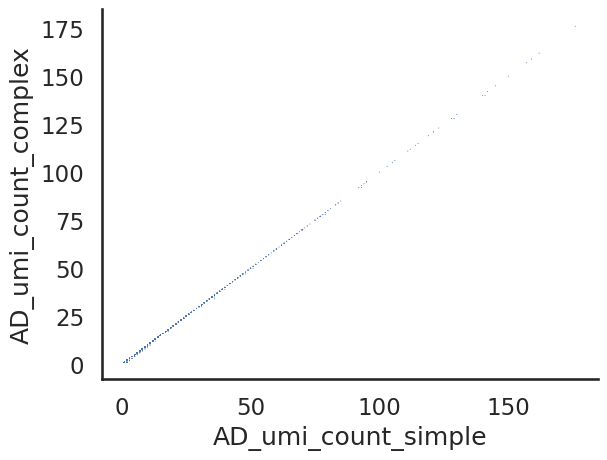

In [54]:
# Both simple and complex counts are roughly y = x which checks out!
sns.scatterplot(data = AD_results_merged, x = "AD_umi_count_simple", y = "AD_umi_count_complex", s  = 0.5, edgecolor = 'none')
sns.despine()
#plt.savefig(os.path.join(output_path, f"AD_umi_count_comparison.png"), bbox_inches='tight')

In [55]:
RTBC_objects = [RPTR_BC]

complex_RPTR_results = []
simple_RPTR_results = []

for file_path in RT_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Get the file naeme to use for output
    umi_path = os.path.join(output_path, f"umi_{name_only}")
    print(umi_path)

    # Extract UMIs and barcodes from reads
    umi_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"umi_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = None,
                                       bc_objects = [RPTR_BC],
                                       reverse_complement = True,
                                       umi_length = 12)
    umi_map = umi_mapper.create_map()

    # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=RTBC_objects,
                                        column_pairs = [],
                                        reads_threshold = 1,
                                        map_order = ['quality_designed'],
                                        step_name=f"umi_{name_only}", 
                                        descriptor = "")
    refiner.refine_map_from_db()

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = RTBC_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        umi_length = 12,
                                                        output_path = umi_path)

    deduplicator.run_both_deduplications()

    # Collect results
    one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
    one_file_complex_results["name"] = name_only
    complex_RPTR_results.append(one_file_complex_results)

    one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
    one_file_simple_results["name"] = name_only
    simple_RPTR_results.append(one_file_simple_results)

Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAACTC_S26
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/ChopTFs_TREBL_exp_spike_in/umi_Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAACTC_S26
Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGACC_S20
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/ChopTFs_TREBL_exp_spike_in/umi_Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGACC_S20
Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAGCTT_S25
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/ChopTFs_TREBL_exp_spike_in/umi_Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAGCTT_S25
Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCATACT_S24
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/ChopTFs_TREBL_exp_spike_in/umi_Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCATACT_S24
Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCCAAT_S28
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/ChopTFs_TREBL_exp_spike_in/umi_Staller_RP_2_60_

In [56]:
all_complex_RPTR_results_df = pd.concat(complex_RPTR_results)
all_complex_RPTR_results_df = all_complex_RPTR_results_df.rename(columns = {"count" : "RPTR_BC_umi_count", "gene" : "RPTR_BC"})
all_complex_RPTR_results_df

,RPTR_BC,RPTR_BC_umi_count,name
0,TTATGATATTTGGA,91,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
1,AAACGTGGTCAGCT,14,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
2,ACTCACAAGGTTTA,2,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
3,ACTGTAAATAACGT,16,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
4,TTCCAAGAATACGA,45,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
...,...,...,...
11776,CATGACGATGTTAT,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...
11777,ACACTGTCCATTGT,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...
11778,TATGTCCCCACTCA,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...
11779,CTACGACAAATAAA,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...


In [57]:
all_simple_RPTR_results_df = pd.concat(simple_RPTR_results)
all_simple_RPTR_results_df = all_simple_RPTR_results_df.rename(columns = {"count" : "RPTR_BC_umi_count"})
all_simple_RPTR_results_df

,RPTR_BC,RPTR_BC_umi_count,name
0,TTGACGAGGGCGGC,260,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
1,CTAGCCTCCCGCCG,255,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
2,GTACGTAGACAGGT,242,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
3,GATCTATAAGATAT,239,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
4,TGACGAAAGAGAAC,226,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
...,...,...,...
11776,GCAGACTGATATAT,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...
11777,TGTCTACTTCATCA,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...
11778,TACCAGGCCTCACG,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...
11779,CAGCGTGACCACGC,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...


In [58]:
RPTR_results_merged = pd.merge(all_complex_RPTR_results_df, all_simple_RPTR_results_df, on = ["RPTR_BC", "name"],suffixes = ("_complex", "_simple"))
RPTR_results_merged

,RPTR_BC,RPTR_BC_umi_count_complex,name,RPTR_BC_umi_count_simple
0,TTATGATATTTGGA,91,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...,91
1,AAACGTGGTCAGCT,14,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...,14
2,ACTCACAAGGTTTA,2,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...,2
3,ACTGTAAATAACGT,16,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...,16
4,TTCCAAGAATACGA,45,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...,45
...,...,...,...,...
173636,CATGACGATGTTAT,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...,1
173637,ACACTGTCCATTGT,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...,1
173638,TATGTCCCCACTCA,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...,1
173639,CTACGACAAATAAA,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...,1


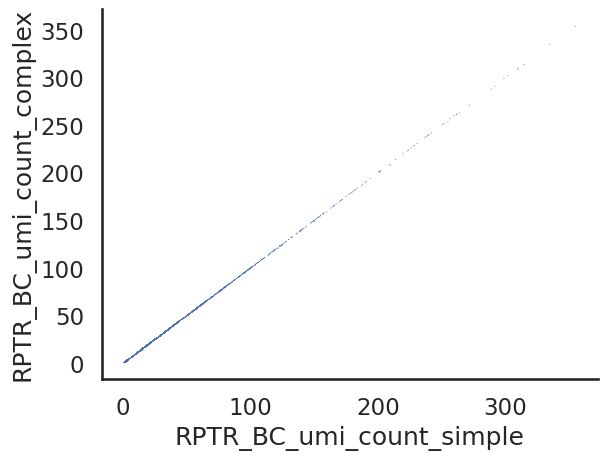

In [59]:
sns.scatterplot(data = RPTR_results_merged, x = "RPTR_BC_umi_count_simple", y = "RPTR_BC_umi_count_complex", s  = 0.5, edgecolor = 'none')
sns.despine()
plt.savefig(os.path.join(output_path, f"RPTR_umi_count_comparison.png"), bbox_inches='tight')

In [60]:
RPTR_results_merged.to_csv(os.path.join(output_path, f"RPTR_BC_results.csv"))

# Merging back to step 1 map

In [16]:
step1_map = refiner.get_map_df('step1_AD_AD_BC_RPTR_BC_quality_designed')
step1_map

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed
0,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1
1,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,ACCAAGGTACT,CAGTAGGCTAGTAA,441,True,True,True,1
2,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,TGATAGAGCGA,GTCAATGCTATACA,309,True,True,True,1
3,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,AGCCGAGTAGA,AATCAGCTGTTGAT,276,True,True,True,1
4,ACTGATGCTATTGATGAAGAAGTTGCTATGTCTGCTGTTATTGAAA...,CCTTTGATTAT,GCTTATAGGTGCGG,252,True,True,True,1
...,...,...,...,...,...,...,...,...
249305,GATTCTACTTCTCCAATTAAATATGAAGCTGATGTTTCTGCTGGTG...,TTTTGCTTTTG,AATAGGCAATCATT,18,True,True,True,1
249306,AAAGCTTATCCTAAAGGTTATACTGAATCTTTGGAAGAAAGAGTTA...,ACGGATCTGAG,CACGAAAACTATAC,18,True,True,True,1
249307,GAGAATGGTAAATGTGGTAAAGCTCCATTGTGGTATAGAGTTAAGA...,GTTCTCCCCCC,TCCTAAGTCGGACC,18,True,True,True,1
249308,GATTATGCTAATGATCCAGAATTGAATAATGTTAATGCTAGAGGTT...,AGATCAACAAC,AATGAGAATAATGA,18,True,True,True,1


In [89]:
# Add simple AD UMI counts to step1 map
step1_map_with_AD = pd.merge(step1_map, AD_results_merged).drop_duplicates()
step1_map_with_AD

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,AD_ADBC_concat,AD_umi_count_complex,name,AD_umi_count_simple
0,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,2,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,2
1,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,2,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,2
2,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,1,Staller_AD_2_0_MVS_0001_AACGCAATTC_TACGGATACG_S9,1
3,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,3,Staller_AD_2_40_MVS_0008_GTCGCACAGA_ATCCAACTCG...,3
4,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,5,Staller_AD_2_50_MVS_0025_I1_CTGGTCCGAT_CACTCCT...,5
...,...,...,...,...,...,...,...,...,...,...,...,...
73446,AATGAAGGTGTTAAACCAAATACTTCTTTGGAAGGTATGACTTCTT...,GAAGTTCACGC,TCTATCCAACCTCT,18,True,True,True,1,AATGAAGGTGTTAAACCAAATACTTCTTTGGAAGGTATGACTTCTT...,1,Staller_AD_2_30_MVS_0007_GCTTGATATC_ATAAGGTGCA...,1
73447,GGTTCTAATTTGAATGGTGAGAATAATAATAATTCATTTCCAGAAG...,CGTACAGCAAA,ATAGCGTTTCATCG,18,True,True,True,1,GGTTCTAATTTGAATGGTGAGAATAATAATAATTCATTTCCAGAAG...,1,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1
73448,GGTTCTAATTTGAATGGTGAGAATAATAATAATTCATTTCCAGAAG...,CGTACAGCAAA,ATAGCGTTTCATCG,18,True,True,True,1,GGTTCTAATTTGAATGGTGAGAATAATAATAATTCATTTCCAGAAG...,2,Staller_AD_2_5_MVS_0003_TGGACTCGAA_CAATACGGAA_S11,2
73449,CAACAACAACCACAACCACAACCAATTCAAACTCAGAATTTGGAAC...,ATAATTAATTA,TTTTCTGATCTGAC,18,True,True,True,1,CAACAACAACCACAACCACAACCAATTCAAACTCAGAATTTGGAAC...,1,Staller_AD_2_30_MVS_0007_GCTTGATATC_ATAAGGTGCA...,1


In [129]:
step1_map_with_AD[["AD", "AD_BC"]].value_counts()

AD                                                                                                                        AD_BC      
AGAGCTAAGATTGAAATTATTAGAATCTTGTCTATTGCTTATGAAACTATTTATTGTGAGAAGAATAAGAGGAAATTGGCTACTACTGATCAAAGACATAATTTGTCTGTCTTGTCTGTT  GGCGGTCTACA    20
AATGCTAATGGTATTAATACTTCTGCTGCTGCTTCTATTAATAATAATATTTCTTCTACTAATAATTCTGCTAATAATTCTTCTTCTAATAATAATGTTTCTACTGTTCCATCTTCTATG  CACAGCCTATA    18
ACTGACTTTATTGATGAAGAAGTTGCTATGTCTGCTGTTATTGAAATGGGTGCTGATAGAATTAAAGAAGCTCCAGAAGCTTGGGCTGGTCAGAATGAATTTGACTTTATGACTGACTTT  GAACAGTTTGT    18
TATCAAGAGAAATTGTTGACATTTCCATCTTATACTGATGTTAAAGAATATTCTAATTCTGCTCATCAATCTGCATTTATTAAAGAAAGATCTCAATTTAATGCTGCTTCATTTCCATTG  TTGAATCTTGG    16
AATGCTGCTACTGCTAAAGTTACTAAAGGTGAAGTTAAACAATTGGTTAATCCAGAAACTACTGCTGCTGCTGCTTTGGCTGCTAAAGCTCAACATTCTAAACCAATTAGACAACCAATT  AGATAAAACCC    14
                                                                                                                                         ..
TTTGTTTCTTCTGGTAATGTTAACTT

In [90]:
# Add RPTR UMI counts to step1 map
step1_map_with_RPTR = pd.merge(step1_map, RPTR_results_merged).drop_duplicates()
step1_map_with_RPTR

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,RPTR_BC_umi_count_complex,name,RPTR_BC_umi_count_simple
0,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,62,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...,62
1,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,2,Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGA...,2
2,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,151,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,151
3,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,54,Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCAT...,54
4,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,139,Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCC...,139
...,...,...,...,...,...,...,...,...,...,...,...
43870,AATAATTCTAAACCATTGTCTCCAGGTTGGACTGATCAAACTGCTT...,AAATATATAAG,CCGCCAAATCGCGA,18,True,True,True,1,2,Staller_RP_2_10_MVS_0036_I1_AGCTTACCTT_CACTTAG...,2
43871,AATAATTCTAAACCATTGTCTCCAGGTTGGACTGATCAAACTGCTT...,AAATATATAAG,CCGCCAAATCGCGA,18,True,True,True,1,24,Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGA...,24
43872,TCTCAATCATTCTTGGATGATACTGTTAAAGAATATACTTTGATTG...,GACGTTGAGCA,ATGAAGCCCTACTC,18,True,True,True,1,1,Staller_RP_2_10_MVS_0036_I1_AGCTTACCTT_CACTTAG...,1
43873,TCTCCACAAGCTTTGTCTGGTCCACCAATGAAGAAATCTGGTACTT...,TCTTTCCATGA,ACGCCTCATGAAAC,18,True,True,True,1,1,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1


In [130]:
step1_map_with_RPTR[["RPTR_BC"]].value_counts()

RPTR_BC       
GATCGAACCCAACC    16
TAAAACCATGTTGT    14
CTGGTTCTGGAGCA    14
GGACGCATGATGAC    14
TAAGATATTACTCT    14
                  ..
TTTTAGTCCAAGAA     1
TTTTATCACCAACC     1
TTTTATGTAAATTT     1
AAACACCCCATTTT     1
AAACACTCAAGTAA     1
Name: count, Length: 16660, dtype: int64

In [91]:
merge_cols = set(step1_map_with_AD.columns) & set(step1_map_with_RPTR.columns)
merge_cols = [col for col in list(merge_cols) if col != "name"]
merge_cols

['RPTR_BC_qual',
 'RPTR_BC',
 'AD_BC_qual',
 'count',
 'AD_qual',
 'AD_BC',
 'AD',
 'Designed']

In [127]:
step1_map_with_AD_RPTR["AD_BC"].value_counts()

AD_BC
GTAATCAAATC    101
TTGCTTACAAA    100
ATAAAAAAGCT    100
ATACCCCCACT    100
GTGATCAGAAT    100
              ... 
GATAATTCCCG      1
GGAGCCGTCTA      1
AGGCGTAGATG      1
CGGTTGTGGCC      1
AATATTGTGAA      1
Name: count, Length: 25010, dtype: int64

In [95]:
step1_map_with_AD_RPTR = pd.merge(step1_map_with_AD, step1_map_with_RPTR, on = merge_cols, how = 'outer', suffixes = ("_AD", "_RPTR"))
step1_map_with_AD_RPTR = step1_map_with_AD_RPTR.fillna(0)
step1_map_with_AD_RPTR

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,AD_ADBC_concat,AD_umi_count_complex,name_AD,AD_umi_count_simple,RPTR_BC_umi_count_complex,name_RPTR,RPTR_BC_umi_count_simple
0,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,4.0,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...,4.0
1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0
2,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,5.0,Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCAT...,5.0
3,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,1.0,Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCC...,1.0
4,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,2.0,Staller_RP_2_15_MVS_0037_I1_ATCAGTGGTC_CTAGGAT...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202612,AATGCTAATGCTGATTCTAATATTGCTGGTAATCCTAAGAATAATG...,TCAGTGTCACG,TTTTTTCGCACACG,13,True,True,True,1,AATGCTAATGCTGATTCTAATATTGCTGGTAATCCTAAGAATAATG...,2.0,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,2.0,3.0,Staller_RP_2_10_MVS_0036_I1_AGCTTACCTT_CACTTAG...,3.0
202613,AATGCTAATGCTGATTCTAATATTGCTGGTAATCCTAAGAATAATG...,TCAGTGTCACG,TTTTTTCGCACACG,13,True,True,True,1,AATGCTAATGCTGATTCTAATATTGCTGGTAATCCTAAGAATAATG...,2.0,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,2.0,17.0,Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGA...,17.0
202614,AATGCTAATGCTGATTCTAATATTGCTGGTAATCCTAAGAATAATG...,TCAGTGTCACG,TTTTTTCGCACACG,13,True,True,True,1,AATGCTAATGCTGATTCTAATATTGCTGGTAATCCTAAGAATAATG...,2.0,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,2.0,2.0,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...,2.0
202615,TTGTCTTCTGTTTCTGTTTCTTCTGGTCATGTTTCTGCTAATTCTC...,TTTTCCTTCGT,TTTTTTCGTTTCGT,42,True,True,True,1,TTGTCTTCTGTTTCTGTTTCTTCTGGTCATGTTTCTGCTAATTCTC...,1.0,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,1.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0


In [134]:
pd.DataFrame(step1_map_with_AD_RPTR[["AD", "AD_BC", "RPTR_BC"]].value_counts()).reset_index()

,AD,AD_BC,RPTR_BC,count
0,TCTCATTTGAGAGTTCATGTTCCATTGAAACCATTTGGTTGTTCTA...,TCATAACAACG,CCCTGAAACTGGCC,100
1,TCTCCAGTTTCTTCTGTTCATACTGCTAACTTCTCTGAAAGAGGTT...,ATAAAGCAGAA,TGCGACGTCATAAT,100
2,GAACAACAATTGATTAGGAAAGTTTATTATTTGTTGTTGATGACTG...,CGGGCCGGATC,TATCCGCCTCAATG,100
3,CATTCTTTGTTGGGTCAATCTTCATTTATGGTTCCAGCTGCTGAGA...,TAACATGCGTA,CAGATCTCTCTCCG,100
4,TTGGCTAATGCTTCTTCTTCTTCTCCAACTGCTTGGATCTTTCATG...,ACTGCAGTCGA,CAAAGACAATTATC,100
...,...,...,...,...
25128,ATGTCTGAGAATACTACTGCTCCATCTGATAATATTACTAATGAAC...,AACAAGTCTGG,CTCATCCCTTCGGC,1
25129,ATGTCTGAGAATCAGAAAGAAGTTTCTCCACCACAAGCTATTTCTG...,GGTAGGTGAAA,AACGGACCCCGAAC,1
25130,AATAAAGTTTCTAATGATTCTAAATTGGACTTTGTTACTGATGATT...,CATGTCGGCAG,GTGCGCCTTGTATT,1
25131,AAATTGAATACTCATCAAGATTCTTCTTATTTGTCTCCAAATACTA...,CGTCAGGACCA,TGCCAAGGCTGTTA,1


In [ ]:
# Trustworthy colony count between step 1 and step 2 - using all AD , AD BC, and RPTR BCs per row

In [109]:
step1_step2_AD_ADBC = pd.merge(step1, step2_new_AD_ADBC_refiner_map, on = ["AD", "AD_BC"])
step1_step2_AD_ADBC

,AD,AD_BC,RPTR_BC,count_x,AD_qual_x,AD_BC_qual_x,RPTR_BC_qual,Designed_x,count_y,AD_qual_y,AD_BC_qual_y,Designed_y
0,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,3494,True,True,1
1,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,ACCAAGGTACT,CAGTAGGCTAGTAA,441,True,True,True,1,339,True,True,1
2,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,TGATAGAGCGA,GTCAATGCTATACA,309,True,True,True,1,630,True,True,1
3,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,AGCCGAGTAGA,AATCAGCTGTTGAT,276,True,True,True,1,246,True,True,1
4,TATGCTATTCCAGAGAATGAATTGTTGGATGAAGATACTATGAACT...,TAGTGGTATCC,TATCCGACAGTATC,216,True,True,True,1,1353,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...
162622,TCTGGTTCTGAAATGCCACCAGATGTTGGTCCAAATAGAATTGCTC...,GAGCCTCCGGA,TTTATCGATTACAT,18,True,True,True,1,36,True,True,1
162623,GATTCTACTTCTCCAATTAAATATGAAGCTGATGTTTCTGCTGGTG...,TTTTGCTTTTG,AATAGGCAATCATT,18,True,True,True,1,69,True,True,1
162624,GAGAATGGTAAATGTGGTAAAGCTCCATTGTGGTATAGAGTTAAGA...,GTTCTCCCCCC,TCCTAAGTCGGACC,18,True,True,True,1,280,True,True,1
162625,GATTATGCTAATGATCCAGAATTGAATAATGTTAATGCTAGAGGTT...,AGATCAACAAC,AATGAGAATAATGA,18,True,True,True,1,76,True,True,1


In [110]:
step1_step2_AD_ADBC_RPTR_BC = pd.merge(step1_step2_AD_ADBC, step2_new_RPTR_refiner_map)
step1_step2_AD_ADBC_RPTR_BC

,AD,AD_BC,RPTR_BC,count_x,AD_qual_x,AD_BC_qual_x,RPTR_BC_qual,Designed_x,count_y,AD_qual_y,AD_BC_qual_y,Designed_y,count,Designed
0,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1,3494,True,True,1,1834,1
1,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,ACCAAGGTACT,CAGTAGGCTAGTAA,441,True,True,True,1,339,True,True,1,155,1
2,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,TGATAGAGCGA,GTCAATGCTATACA,309,True,True,True,1,630,True,True,1,298,1
3,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,AGCCGAGTAGA,AATCAGCTGTTGAT,276,True,True,True,1,246,True,True,1,113,1
4,TATGCTATTCCAGAGAATGAATTGTTGGATGAAGATACTATGAACT...,TAGTGGTATCC,TATCCGACAGTATC,216,True,True,True,1,1353,True,True,1,497,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159752,CCAATTGTTCATTCTCCAACTTTGATGATGTTGTATAATAATCAAA...,AACGCTAAATG,CTACGGCGCCAACC,18,True,True,True,1,29,True,True,1,23,1
159753,TCTGGTTCTGAAATGCCACCAGATGTTGGTCCAAATAGAATTGCTC...,GAGCCTCCGGA,TTTATCGATTACAT,18,True,True,True,1,36,True,True,1,68,1
159754,GATTCTACTTCTCCAATTAAATATGAAGCTGATGTTTCTGCTGGTG...,TTTTGCTTTTG,AATAGGCAATCATT,18,True,True,True,1,69,True,True,1,74,1
159755,GAGAATGGTAAATGTGGTAAAGCTCCATTGTGGTATAGAGTTAAGA...,GTTCTCCCCCC,TCCTAAGTCGGACC,18,True,True,True,1,280,True,True,1,344,1


In [118]:
# Merged with permissive experiment
columns =  ["AD", "AD_BC", "RPTR_BC"]
experiment_with_step1_step2 = pd.merge(step1_map_with_AD_RPTR, step1_step2_AD_ADBC_RPTR_BC[columns], on =columns)
experiment_with_step1_step2

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,AD_ADBC_concat,AD_umi_count_complex,name_AD,AD_umi_count_simple,RPTR_BC_umi_count_complex,name_RPTR,RPTR_BC_umi_count_simple
0,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,4.0,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...,4.0
1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0
2,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,5.0,Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCAT...,5.0
3,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,1.0,Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCC...,1.0
4,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,2.0,Staller_RP_2_15_MVS_0037_I1_ATCAGTGGTC_CTAGGAT...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190655,CAAACTCAACAAACTGAATCTATGGCTACTTCTGTTTCTTCTTCTC...,CTCAGGGATCA,TTTTTCCTTCCCGA,13,True,True,True,1,CAAACTCAACAAACTGAATCTATGGCTACTTCTGTTTCTTCTTCTC...,2.0,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,2.0,1.0,Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGA...,1.0
190656,CAAACTCAACAAACTGAATCTATGGCTACTTCTGTTTCTTCTTCTC...,CTCAGGGATCA,TTTTTCCTTCCCGA,13,True,True,True,1,CAAACTCAACAAACTGAATCTATGGCTACTTCTGTTTCTTCTTCTC...,2.0,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,2.0,2.0,Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGA...,2.0
190657,ACTTGGAGGAAGATTTGGTATTATATTGTTTCTATGGATGTTAATC...,AGGACCAATTA,TTTTTGAAAATTAG,18,True,True,True,1,ACTTGGAGGAAGATTTGGTATTATATTGTTTCTATGGATGTTAATC...,1.0,Staller_AD_2_20_MVS_0006_TCCAGCCTAA_AATCCGCGCT...,1.0,0.0,0,0.0
190658,TTGTCTTCTGTTTCTGTTTCTTCTGGTCATGTTTCTGCTAATTCTC...,TTTTCCTTCGT,TTTTTTCGTTTCGT,42,True,True,True,1,TTGTCTTCTGTTTCTGTTTCTTCTGGTCATGTTTCTGCTAATTCTC...,1.0,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,1.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0


In [135]:
experiment_with_step1_step2[["AD", "AD_BC", "RPTR_BC"]].value_counts()

AD                                                                                                                        AD_BC        RPTR_BC       
GCTAATTGTGCTCCAGATTCTGTTACTCCATTGGATTCTTCTGTCTTGACTGGTCCACCACCTAAGAATATGGATAATTTGCCAGCTGTTTCTTCTAATTTGATTAATTCTCCAATGAAT  ATAAAAAAGCT  AAACAATTGGTCGA    100
TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATAATATGAAAGAATGGACTTCTTTGTTTGATAATGATATTTCTGTTAATACTGATGATTTGTCTTTGGCTGATAAA  CCATCCACCGG  CTAGCCTCCCGCCG    100
CCACCTAAGATTCCTAAGAAAGTTTATACTTTGGAAGAAATTCCAGTTGAATATAGAACTAAACCAACTGTTTCTTATTCTGCTATGTTGACTACTTGTATTAGGAAATATTCTACTGCT  GCCGTTAAAAC  TAATCAATCCTAGT    100
GCTTATATTGCTGGTTTGAAAGAATTTCAAGATGAAACTAATGAAATTTCTTTGGAGAAGAAACAAGAATTGTTGGATTTGATCTTTCCATCTAATTTGGCTGATATCTTGGTTCAAAGA  AAACATAATAC  ATAAACTTGTTATC    100
AAACAGAAGATGTTTCACTTTAGACAGAATGTCTTGTCTCATTTGACTGATGAAGAGTTCTTGTCTCCAATTAATGAAATGTTTACTACTACATTTAAATATTCTATCTTGCAAACTAAA  TCAAGTAAACA  TCGAATGACATCCT    100
                                                                 

In [ ]:
# Reads per concat? 

In [119]:
experiment_with_step1_step2[experiment_with_step1_step2["AD_umi_count_simple"] == 0]

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,AD_ADBC_concat,AD_umi_count_complex,name_AD,AD_umi_count_simple,RPTR_BC_umi_count_complex,name_RPTR,RPTR_BC_umi_count_simple
36,AAGAAACAAGCTAAGAGATTGTTGGAGAACTTTCATGCTACTTTGT...,TCTTTTGAGAG,AAAACAACCTAGAA,16,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCAT...,1.0
60,GAATCTTCTAATAATAATGAAATTGGTGGTTATTTGAGAGGTGGTA...,GACGAAGGGTA,AAAACCTTTACACA,19,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGA...,1.0
61,TATATGACTGAATCTGAAGTCTTGGCTACTTTGTGTGAAATGTTGC...,CCTTCTTCCGA,AAAACGAAATGTTG,14,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGA...,1.0
62,TATATGACTGAATCTGAAGTCTTGGCTACTTTGTGTGAAATGTTGC...,CCTTCTTCCGA,AAAACGAAATGTTG,14,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0
77,ATTATTAGATCTATCTTGGAAAGATATGCTCCAATCTTTATTTCTT...,CGTAAAGCAAT,AAAACTCGACCGTA,16,True,True,True,1,0,0.0,0,0.0,2.0,Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCC...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190476,TCTACTTCTTCTAATCCAGCTCAATTGGCTGCTTCTCAATTGAATC...,AGCTAAAATTC,TTTTCTTATGAGCA,24,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCAT...,1.0
190510,ATCTTGTTGAGATGCTTCTATCAGAATATTTATCCATTCTATCCAT...,CTGACCGGTCC,TTTTGACCTCGAAT,28,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0
190530,AAATTGGAATTGCCAGATAATTTGGATAATGCTGACTTCTCTAAAT...,TGATCTTGATG,TTTTGATTGTGTTC,12,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0
190531,AAATTGGAATTGCCAGATAATTTGGATAATGCTGACTTCTCTAAAT...,TGATCTTGATG,TTTTGATTGTGTTC,12,True,True,True,1,0,0.0,0,0.0,4.0,Staller_RP_2_15_MVS_0037_I1_ATCAGTGGTC_CTAGGAT...,4.0


In [120]:
experiment_with_step1_step2[experiment_with_step1_step2["RPTR_BC_umi_count_simple"] == 0]

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,AD_ADBC_concat,AD_umi_count_complex,name_AD,AD_umi_count_simple,RPTR_BC_umi_count_complex,name_RPTR,RPTR_BC_umi_count_simple
17,AATCCATCTGGATTTGCTAAAGATACTCAAGATGAAGAATATGTTC...,TAGACCAACAT,AAAAACCGGAGATT,43,True,True,True,1,AATCCATCTGGATTTGCTAAAGATACTCAAGATGAAGAATATGTTC...,1.0,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,1.0,0.0,0,0.0
34,GGTAAAGTTGCTGCTACTACTGCTGTTGTTGTTAAAGAAGAAGAAG...,TTCACTATAGT,AAAAATTGGAGCTT,18,True,True,True,1,GGTAAAGTTGCTGCTACTACTGCTGTTGTTGTTAAAGAAGAAGAAG...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,0.0,0,0.0
35,GGTAAAGTTGCTGCTACTACTGCTGTTGTTGTTAAAGAAGAAGAAG...,TTCACTATAGT,AAAAATTGGAGCTT,18,True,True,True,1,GGTAAAGTTGCTGCTACTACTGCTGTTGTTGTTAAAGAAGAAGAAG...,1.0,Staller_AD_2_5_MVS_0003_TGGACTCGAA_CAATACGGAA_S11,1.0,0.0,0,0.0
37,TCTAATACTGTTCCATCTACTCCATCTAGATCTAATTCTGTCTTGT...,ACAATTATACT,AAAACATGACCAAT,14,True,True,True,1,TCTAATACTGTTCCATCTACTCCATCTAGATCTAATTCTGTCTTGT...,1.0,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,1.0,0.0,0,0.0
38,TCTAATACTGTTCCATCTACTCCATCTAGATCTAATTCTGTCTTGT...,ACAATTATACT,AAAACATGACCAAT,14,True,True,True,1,TCTAATACTGTTCCATCTACTCCATCTAGATCTAATTCTGTCTTGT...,1.0,Staller_AD_2_50_MVS_0025_I1_CTGGTCCGAT_CACTCCT...,1.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190644,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,AACACCCCTCA,TTTTTATGAGATTT,24,True,True,True,1,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,1.0,Staller_AD_2_50_MVS_0025_I1_CTGGTCCGAT_CACTCCT...,1.0,0.0,0,0.0
190645,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,AACACCCCTCA,TTTTTATGAGATTT,24,True,True,True,1,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,1.0,Staller_AD_2_5_MVS_0003_TGGACTCGAA_CAATACGGAA_S11,1.0,0.0,0,0.0
190646,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,AACACCCCTCA,TTTTTATGAGATTT,24,True,True,True,1,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,1.0,Staller_AD_2_30_MVS_0007_GCTTGATATC_ATAAGGTGCA...,1.0,0.0,0,0.0
190647,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,AACACCCCTCA,TTTTTATGAGATTT,24,True,True,True,1,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,1.0,Staller_AD_2_2_MVS_0002_CGTCGCTAAG_TCCTGGTATT_S10,1.0,0.0,0,0.0


In [122]:
experiment_with_step1_step2[(experiment_with_step1_step2["AD_umi_count_simple"] != 0) & (experiment_with_step1_step2["RPTR_BC_umi_count_simple"] == 0)]

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,AD_ADBC_concat,AD_umi_count_complex,name_AD,AD_umi_count_simple,RPTR_BC_umi_count_complex,name_RPTR,RPTR_BC_umi_count_simple
17,AATCCATCTGGATTTGCTAAAGATACTCAAGATGAAGAATATGTTC...,TAGACCAACAT,AAAAACCGGAGATT,43,True,True,True,1,AATCCATCTGGATTTGCTAAAGATACTCAAGATGAAGAATATGTTC...,1.0,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,1.0,0.0,0,0.0
34,GGTAAAGTTGCTGCTACTACTGCTGTTGTTGTTAAAGAAGAAGAAG...,TTCACTATAGT,AAAAATTGGAGCTT,18,True,True,True,1,GGTAAAGTTGCTGCTACTACTGCTGTTGTTGTTAAAGAAGAAGAAG...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,0.0,0,0.0
35,GGTAAAGTTGCTGCTACTACTGCTGTTGTTGTTAAAGAAGAAGAAG...,TTCACTATAGT,AAAAATTGGAGCTT,18,True,True,True,1,GGTAAAGTTGCTGCTACTACTGCTGTTGTTGTTAAAGAAGAAGAAG...,1.0,Staller_AD_2_5_MVS_0003_TGGACTCGAA_CAATACGGAA_S11,1.0,0.0,0,0.0
37,TCTAATACTGTTCCATCTACTCCATCTAGATCTAATTCTGTCTTGT...,ACAATTATACT,AAAACATGACCAAT,14,True,True,True,1,TCTAATACTGTTCCATCTACTCCATCTAGATCTAATTCTGTCTTGT...,1.0,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,1.0,0.0,0,0.0
38,TCTAATACTGTTCCATCTACTCCATCTAGATCTAATTCTGTCTTGT...,ACAATTATACT,AAAACATGACCAAT,14,True,True,True,1,TCTAATACTGTTCCATCTACTCCATCTAGATCTAATTCTGTCTTGT...,1.0,Staller_AD_2_50_MVS_0025_I1_CTGGTCCGAT_CACTCCT...,1.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190644,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,AACACCCCTCA,TTTTTATGAGATTT,24,True,True,True,1,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,1.0,Staller_AD_2_50_MVS_0025_I1_CTGGTCCGAT_CACTCCT...,1.0,0.0,0,0.0
190645,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,AACACCCCTCA,TTTTTATGAGATTT,24,True,True,True,1,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,1.0,Staller_AD_2_5_MVS_0003_TGGACTCGAA_CAATACGGAA_S11,1.0,0.0,0,0.0
190646,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,AACACCCCTCA,TTTTTATGAGATTT,24,True,True,True,1,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,1.0,Staller_AD_2_30_MVS_0007_GCTTGATATC_ATAAGGTGCA...,1.0,0.0,0,0.0
190647,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,AACACCCCTCA,TTTTTATGAGATTT,24,True,True,True,1,AAACCAACTGTTGTTAATGATTATGAAGCTGCTAGAGCTATTCCAA...,1.0,Staller_AD_2_2_MVS_0002_CGTCGCTAAG_TCCTGGTATT_S10,1.0,0.0,0,0.0


In [123]:
experiment_with_step1_step2[(experiment_with_step1_step2["AD_umi_count_simple"] == 0) & (experiment_with_step1_step2["RPTR_BC_umi_count_simple"] != 0)]

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,AD_ADBC_concat,AD_umi_count_complex,name_AD,AD_umi_count_simple,RPTR_BC_umi_count_complex,name_RPTR,RPTR_BC_umi_count_simple
36,AAGAAACAAGCTAAGAGATTGTTGGAGAACTTTCATGCTACTTTGT...,TCTTTTGAGAG,AAAACAACCTAGAA,16,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCAT...,1.0
60,GAATCTTCTAATAATAATGAAATTGGTGGTTATTTGAGAGGTGGTA...,GACGAAGGGTA,AAAACCTTTACACA,19,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGA...,1.0
61,TATATGACTGAATCTGAAGTCTTGGCTACTTTGTGTGAAATGTTGC...,CCTTCTTCCGA,AAAACGAAATGTTG,14,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGA...,1.0
62,TATATGACTGAATCTGAAGTCTTGGCTACTTTGTGTGAAATGTTGC...,CCTTCTTCCGA,AAAACGAAATGTTG,14,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0
77,ATTATTAGATCTATCTTGGAAAGATATGCTCCAATCTTTATTTCTT...,CGTAAAGCAAT,AAAACTCGACCGTA,16,True,True,True,1,0,0.0,0,0.0,2.0,Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCC...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190476,TCTACTTCTTCTAATCCAGCTCAATTGGCTGCTTCTCAATTGAATC...,AGCTAAAATTC,TTTTCTTATGAGCA,24,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCAT...,1.0
190510,ATCTTGTTGAGATGCTTCTATCAGAATATTTATCCATTCTATCCAT...,CTGACCGGTCC,TTTTGACCTCGAAT,28,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0
190530,AAATTGGAATTGCCAGATAATTTGGATAATGCTGACTTCTCTAAAT...,TGATCTTGATG,TTTTGATTGTGTTC,12,True,True,True,1,0,0.0,0,0.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0
190531,AAATTGGAATTGCCAGATAATTTGGATAATGCTGACTTCTCTAAAT...,TGATCTTGATG,TTTTGATTGTGTTC,12,True,True,True,1,0,0.0,0,0.0,4.0,Staller_RP_2_15_MVS_0037_I1_ATCAGTGGTC_CTAGGAT...,4.0


In [125]:
experiment_with_step1_step2[(experiment_with_step1_step2["AD_umi_count_simple"] != 0) & (experiment_with_step1_step2["RPTR_BC_umi_count_simple"] != 0)].drop_duplicates()

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,AD_ADBC_concat,AD_umi_count_complex,name_AD,AD_umi_count_simple,RPTR_BC_umi_count_complex,name_RPTR,RPTR_BC_umi_count_simple
0,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,4.0,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...,4.0
1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0
2,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,5.0,Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCAT...,5.0
3,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,1.0,Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCC...,1.0
4,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,AAATAAACCAC,AAAAAAAGATAAGT,17,True,True,True,1,TCTGAATGTAAGACTTCTTATGGTAATGAATTGTCTTTGTCTAATA...,1.0,Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGAT...,1.0,2.0,Staller_RP_2_15_MVS_0037_I1_ATCAGTGGTC_CTAGGAT...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190654,CAAACTCAACAAACTGAATCTATGGCTACTTCTGTTTCTTCTTCTC...,CTCAGGGATCA,TTTTTCCTTCCCGA,13,True,True,True,1,CAAACTCAACAAACTGAATCTATGGCTACTTCTGTTTCTTCTTCTC...,2.0,Staller_AD_2_2_MVS_0002_CGTCGCTAAG_TCCTGGTATT_S10,2.0,2.0,Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGA...,2.0
190655,CAAACTCAACAAACTGAATCTATGGCTACTTCTGTTTCTTCTTCTC...,CTCAGGGATCA,TTTTTCCTTCCCGA,13,True,True,True,1,CAAACTCAACAAACTGAATCTATGGCTACTTCTGTTTCTTCTTCTC...,2.0,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,2.0,1.0,Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGA...,1.0
190656,CAAACTCAACAAACTGAATCTATGGCTACTTCTGTTTCTTCTTCTC...,CTCAGGGATCA,TTTTTCCTTCCCGA,13,True,True,True,1,CAAACTCAACAAACTGAATCTATGGCTACTTCTGTTTCTTCTTCTC...,2.0,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...,2.0,2.0,Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGA...,2.0
190658,TTGTCTTCTGTTTCTGTTTCTTCTGGTCATGTTTCTGCTAATTCTC...,TTTTCCTTCGT,TTTTTTCGTTTCGT,42,True,True,True,1,TTGTCTTCTGTTTCTGTTTCTTCTGGTCATGTTTCTGCTAATTCTC...,1.0,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...,1.0,1.0,Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAG...,1.0


In [93]:
step1_map_with_AD_RPTR["AD"].value_counts()

AD
AGAGCTTCTACTGGATTCTGTGCATTCTTGTATCATAAATTGACTTTGTTTGAGAAAGGTTATTATTTGTCTTCTAATATTAAAGATCAAGAAGTTACTGATTGGGATTTGTCTACTTTG    284
TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATAATATGAAAGAATGGACTTCTTTGTTTGATAATGATATTTCTGTTAATACTGATGATTTGTCTTTGGCTGATAAA    267
AACTTCTTGTTTCCAAGAGCTTCTACTGGATTCTGTGCATTCTTGTATCATAAATTGACTTTGTTTGAGAAAGGTTATTATTTGTCTTCTAATATTAAAGATCAAGAAGTTACTGATTGG    245
ATTTCTGCTCAAGAGTTCTCTAGAAACTTTACTGAAGATGTTGATGAATCTTTGCAATCTGAAATTGATTTGATGAATTATGATAATGAAGCTTTGAATCAATTGATGGCTATTGATTTG    236
TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACTTTGATACATTTGATATTTCTCCAAACTTTGGTCATTCTGATTTGGAGAATCCAGATACTTGGTTCTCTTTGTTT    223
                                                                                                                           ... 
TCTTCTAATAGAGAACAAGATTCTGTTGATACTTATTCTAATATTCCAGTTGGTAGAGAAATTAAGATTATCTTGCCACCTAAAGCTATTGCTTTGCAATTTGTTAAATCTACTTGGGAA      1
CCAAGAGATTCTCCTAAGAGAGATGATTCTATGGCTACTTCTGCTGCTACTGCTGCTTCTGCTAAACCAGATGCTTTGACTATTGGTAAAGAAGGTATTGT

## TREBL experiment bc quality loss

In [13]:
df

,RPTR_BC,RPTR_BC_qual,UMI,Designed
0,CCTGGCCACCTACA,True,AGCTGGGACTTA,1
1,CATTATCGCTAAGG,True,CCGCACAGAAAT,1
2,GGCATCGCATATAG,True,CGACTGGCGCCT,1
3,CTACCATTCGATACACAAAC,False,TTACGCCGAATA,1
4,CCCCTACACCAGGA,True,CTAACCGATGAA,1
...,...,...,...,...
123251,TGTGAAGGACCTCA,True,AACGCCGACAAG,1
123252,GGCACATGATATGC,True,ATCCAATCCATC,1
123253,ACCTTGTCCCTGCA,True,AGTGGATCACCC,1
123254,AGCACGACTCAGTT,True,ACCTAAGGTCCG,1


In [17]:
step1_map

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed
0,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TACAACAAATA,CAAAAGAAAACACG,568,True,True,True,1
1,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,ACCAAGGTACT,CAGTAGGCTAGTAA,441,True,True,True,1
2,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,TGATAGAGCGA,GTCAATGCTATACA,309,True,True,True,1
3,CCATCTCCATCTTCTTCTGTTGATAATTTGAATGATTATTTGACTG...,AGCCGAGTAGA,AATCAGCTGTTGAT,276,True,True,True,1
4,ACTGATGCTATTGATGAAGAAGTTGCTATGTCTGCTGTTATTGAAA...,CCTTTGATTAT,GCTTATAGGTGCGG,252,True,True,True,1
...,...,...,...,...,...,...,...,...
249305,GATTCTACTTCTCCAATTAAATATGAAGCTGATGTTTCTGCTGGTG...,TTTTGCTTTTG,AATAGGCAATCATT,18,True,True,True,1
249306,AAAGCTTATCCTAAAGGTTATACTGAATCTTTGGAAGAAAGAGTTA...,ACGGATCTGAG,CACGAAAACTATAC,18,True,True,True,1
249307,GAGAATGGTAAATGTGGTAAAGCTCCATTGTGGTATAGAGTTAAGA...,GTTCTCCCCCC,TCCTAAGTCGGACC,18,True,True,True,1
249308,GATTATGCTAATGATCCAGAATTGAATAATGTTAATGCTAGAGGTT...,AGATCAACAAC,AATGAGAATAATGA,18,True,True,True,1


umi_Staller_AD_2_0_MVS_0001_AACGCAATTC_TACGGATACG_S9_AD_AD_BC_initial step1 count: 14650
umi_Staller_AD_2_2_MVS_0002_CGTCGCTAAG_TCCTGGTATT_S10_AD_AD_BC_initial step1 count: 11450
umi_Staller_AD_2_5_MVS_0003_TGGACTCGAA_CAATACGGAA_S11_AD_AD_BC_initial step1 count: 12811
umi_Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA_S12_AD_AD_BC_initial step1 count: 13007
umi_Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13_AD_AD_BC_initial step1 count: 15606
umi_Staller_AD_2_20_MVS_0006_TCCAGCCTAA_AATCCGCGCT_S14_AD_AD_BC_initial step1 count: 13184
umi_Staller_AD_2_30_MVS_0007_GCTTGATATC_ATAAGGTGCA_S15_AD_AD_BC_initial step1 count: 13070
umi_Staller_AD_2_40_MVS_0008_GTCGCACAGA_ATCCAACTCG_S16_AD_AD_BC_initial step1 count: 12341
umi_Staller_AD_2_50_MVS_0025_I1_CTGGTCCGAT_CACTCCTCAC_S17_AD_AD_BC_initial step1 count: 12946
umi_Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGATTGA_S18_AD_AD_BC_initial step1 count: 12721
umi_Staller_RP_2_0_MVS_0033_I1_AAGAGGCTAA_CGATAAGGCG_S19_RPTR_BC_initial step1 count: 10

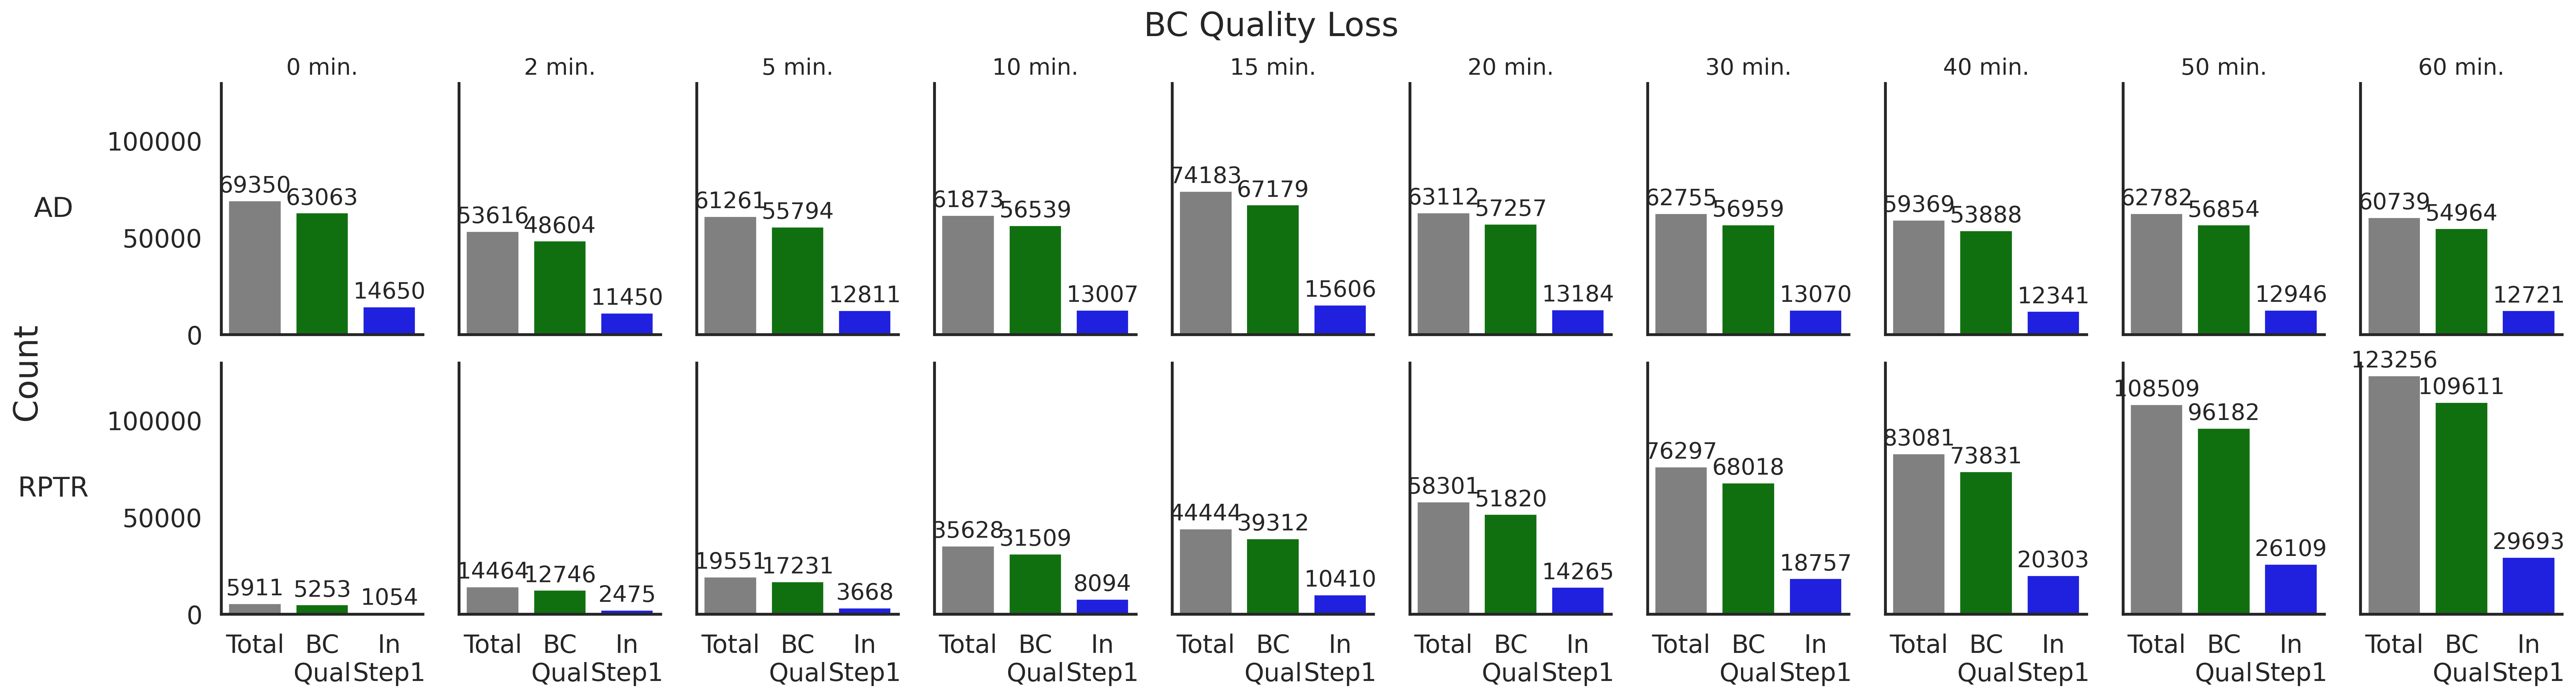

In [25]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Get all available tables ===
tables = [r[0] for r in refiner.con.execute(
    "SELECT name FROM sqlite_master WHERE type='table';"
).fetchall()]

# Filter AD and RPTR separately, ignoring intermediate 'step' tables
ad_tables = [t for t in tables if "_AD_AD_BC_initial" in t and "step" not in t]
rp_tables = [t for t in tables if "_RPTR_BC_initial" in t and "step" not in t]

# === 2. Sort numerically by the 2_### pattern ===
def extract_sort_key(name, pattern):
    """Extract integer part of '2_###' for sorting."""
    match = re.search(pattern, name)
    if match:
        num_part = match.group(1).split('_')[1]
        return int(num_part)
    return float('inf')

ad_tables = sorted(ad_tables, key=lambda x: extract_sort_key(x, r'_AD_(2_\d+)_'))
rp_tables = sorted(rp_tables, key=lambda x: extract_sort_key(x, r'_RP_(2_\d+)_'))

# === 3. Set up figure ===
fig, axes = plt.subplots(
    2, max(len(ad_tables), len(rp_tables)),
    figsize=(24, 6), dpi=300, sharey=True, sharex=True
)
axes = axes.flatten()

# === 4. AD row ===
for i, table in enumerate(ad_tables):
    df = refiner.get_map_df(table)
    total_count = len(df)
    qual_count = df["AD_BC_qual"].sum() if "AD_BC_qual" in df else 0
    step1_count = len(df[(df["AD"].isin(step1_map["AD"])) & (df["AD_BC"].isin(step1_map["AD_BC"]))])
    print(f"{table} step1 count: {step1_count}")

    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC\nQual", "In\nStep1"],
        "Count": [total_count, qual_count, step1_count]
    })

    ax = axes[i]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    # Extract short code (e.g., "2_5") for title
    match = re.search(r'_AD_2_(\d+)_', table)
    title = match.group(1) if match else table
    ax.set_title(title + " min.", fontsize='small')
    ax.set_xlabel("")
    ax.set_ylabel("")

# === 5. RPTR row ===
for i, table in enumerate(rp_tables):
    df = refiner.get_map_df(table)
    total_count = len(df)
    qual_count = df["RPTR_BC_qual"].sum() if "RPTR_BC_qual" in df else 0
    step1_count = len(df[(df["RPTR_BC"].isin(step1_map["RPTR_BC"]))])
    print(f"{table} step1 count: {step1_count}")

    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC\nQual", "In\nStep1"],
        "Count": [total_count, qual_count, step1_count]
    })

    ax = axes[len(ad_tables) + i]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)
    ax.set_ylabel("")
    ax.set_xlabel("")

# === 6. Aesthetic cleanup ===
axes[0].set_ylabel("AD", rotation=0, labelpad=35, va='center')
axes[len(ad_tables)].set_ylabel("RPTR", rotation=0, labelpad=35, va='center')

fig.supylabel("Count")
sns.despine()
plt.tight_layout(pad=0.5)
fig.suptitle("BC Quality Loss", y=1.05)

# === 7. Show / save ===
plt.savefig(os.path.join(output_path, "bc_quality_loss.png"))
plt.show()

## TREBL experiment reads per umi

In [97]:
ADBC_reads_per_umi = []

for file_path in AD_seq_files:
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = AD_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        umi_length = 12,
                                                        output_path = umi_path)

    one_file_reads_per_UMI = deduplicator.counts_per_umi()
    one_file_reads_per_UMI["name"] = name_only
    ADBC_reads_per_umi.append(one_file_reads_per_UMI)
    
ADBC_reads_per_umi = pd.concat(ADBC_reads_per_umi)
ADBC_reads_per_umi

Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13
Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGATTGA_S18
Staller_AD_2_0_MVS_0001_AACGCAATTC_TACGGATACG_S9
Staller_AD_2_40_MVS_0008_GTCGCACAGA_ATCCAACTCG_S16
Staller_AD_2_50_MVS_0025_I1_CTGGTCCGAT_CACTCCTCAC_S17
Staller_AD_2_20_MVS_0006_TCCAGCCTAA_AATCCGCGCT_S14
Staller_AD_2_5_MVS_0003_TGGACTCGAA_CAATACGGAA_S11
Staller_AD_2_30_MVS_0007_GCTTGATATC_ATAAGGTGCA_S15
Staller_AD_2_2_MVS_0002_CGTCGCTAAG_TCCTGGTATT_S10
Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA_S12


,AD,AD_BC,UMI,reads,name
0,AAAAATTCATTCTCTTTGGCTAAATCTGAAGAATCTACTAATGATT...,ATAACCAATGG,AAGAGCATTGAA,1,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...
1,AAAAATTCATTCTCTTTGGCTAAATCTGAAGAATCTACTAATGATT...,ATAACCAATGG,GACATGACTAAC,1,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...
2,AAAAATTCATTCTCTTTGGCTAAATCTGAAGAATCTACTAATGATT...,ATAACCAATGG,CCCAGTGAATGA,1,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...
3,AAAAATTCATTCTCTTTGGCTAAATCTGAAGAATCTACTAATGATT...,TATCTTCGCTT,ATACAATAAGAC,1,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...
4,AAAAATTCTAAGAGACAGAAATCTTCTACTTATACTTCTCAAACTT...,TTGCATAGCTG,GTGGCGGACCGG,1,Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA...
...,...,...,...,...,...
35866,TTTGTTTCTTTGTTGGATACTCCATCTAAGAAATCTGATTCTAAAT...,TGGCTCAATAC,AACTCAGGCGGA,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...
35867,TTTGTTTGTGATTATTGTGGTAAGAGATTTACTCAAGGTGGTAATT...,GATCCCATGCA,ATCGCAACCTTT,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...
35868,TTTGTTTGTGATTATTGTGGTAAGAGATTTACTCAAGGTGGTAATT...,GATCCCATGCA,CGATAACAAACA,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...
35869,TTTGTTTGTGATTATTGTGGTAAGAGATTTACTCAAGGTGGTAATT...,TACAACTTTAT,AACCTACTCTAG,1,Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA...


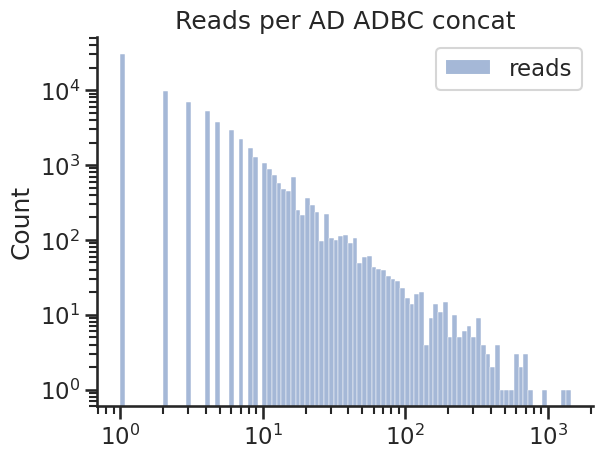

In [102]:
sns.set_context('talk')
sns.histplot(ADBC_reads_per_umi[["AD", "AD_BC", "reads"]].groupby(["AD", "AD_BC"]).sum(), log_scale = (True, True))
plt.title("Reads per AD ADBC concat")
sns.despine()

In [142]:
ADBC_reads_per_umi.to_csv(os.path.join(output_path, f"ADBC_reads_per_umi.csv"))

In [103]:
RTBC_reads_per_umi = []
for file_path in RT_seq_files:
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = RTBC_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        umi_length = 12,
                                                        output_path = umi_path)

    one_file_reads_per_UMI = deduplicator.counts_per_umi()
    one_file_reads_per_UMI["name"] = name_only
    RTBC_reads_per_umi.append(one_file_reads_per_UMI)
RTBC_reads_per_umi = pd.concat(RTBC_reads_per_umi)
RTBC_reads_per_umi

Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAACTC_S26
Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGACC_S20
Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAGCTT_S25
Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCATACT_S24
Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCCAAT_S28
Staller_RP_2_15_MVS_0037_I1_ATCAGTGGTC_CTAGGATCTA_S23
Staller_RP_2_0_MVS_0033_I1_AAGAGGCTAA_CGATAAGGCG_S19
Staller_RP_2_10_MVS_0036_I1_AGCTTACCTT_CACTTAGCAC_S22
Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGAGTA_S27
Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAACA_S21


,RPTR_BC,UMI,reads,name
0,AAAAAAAGATAAGT,AGCCCAGGATGA,1,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
1,AAAAAAAGATAAGT,ACATCCGACACC,1,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
2,AAAAAAAGATAAGT,GAAATCCCCCTC,1,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
3,AAAAAAAGATAAGT,CCGTCGGACACA,1,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
4,AAAAACACATAAAA,GCTGCGGCGGTT,1,Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAA...
...,...,...,...,...
16829,TTTTTCGGGTGATG,CGCGGAAAAACC,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...
16830,TTTTTGAGCTCGCC,AAAGAGTGCCAC,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...
16831,TTTTTGTATCCACC,ATGTGAAGAGAG,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...
16832,TTTTTTCGCACACG,AATGGCTATTCG,1,Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAA...


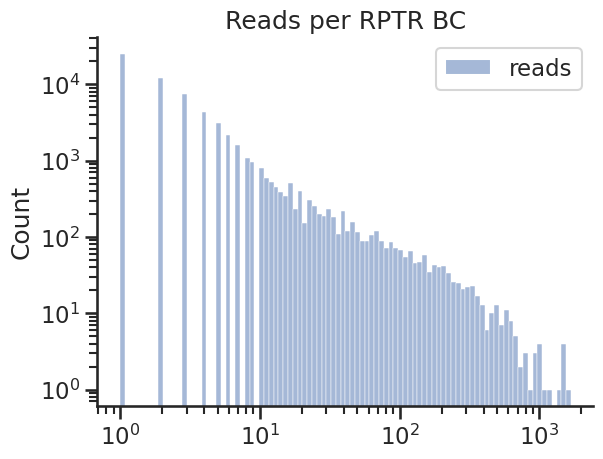

In [104]:
sns.set_context('talk')
sns.histplot(RTBC_reads_per_umi[["RPTR_BC", "reads"]].groupby(["RPTR_BC"]).sum(), log_scale = (True, True))
plt.title("Reads per RPTR BC")
sns.despine()

In [141]:
RTBC_reads_per_umi.to_csv(os.path.join(output_path, f"RPTR_BC_reads_per_umi.csv"))